# Homestuck Census Data Analysis Notebook

A CUDA-accelerated notebook for visualizing and analyzing Homestuck fandom census data. Check requirements.txt if you wanna run this.


In [217]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import hdbscan
import umap
from sklearn.manifold import TSNE
import plotly.express as px
import altair as alt
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Settings
pd.set_option('future.no_silent_downcasting', True)

# Load data
csv_path = 'census_results.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Drop the first five rows (test data)
df.drop(index=[0, 1, 2, 3, 4], inplace=True)

print(list(df.columns))

# Private and useless data (duplicated rows and such)
columns_to_drop = [
    # Private rows
    "Leave your email here if you want to be contacted about the projects above",
    # Useless for variable analysis
    "Which 3 characters had the best complete arc?",
    "Which 3 characters had the worst arc?",
    "Are you participating or have you ever participated in one of /r/homestuck's group rereads?",
    "Would you be interested in giving track art to an official Homestuck album that doesn't have it? (i.e. Beyond Canon Art Anthology)",
    "Would you be interested in contributing a track to a fanmusic album? (i.e. Land of Fans and Music) ",
    "Would you be interested in contributing track art to a fanmusic album? (i.e. Land of Fans and Music) ",
    "Did you fund the Homestuck Kickstarter?",
    "Do you want more official Homestuck musicians to individually add all their Homestuck songs to streaming, à la Bowmanstuck?",
    "If you have any feedback to improve future surveys, here's your chance!",
    "Share your merch wishlist beyond the above",
    # Removed or changed at some point (only had data for the previous columns)
    "Do you want to order a full list or lazily select your top 3 characters and call it a day?",
    "Which of these Homestuck franchiselets have you perused? [Bard Quest]",
    "Which of these Homestuck franchiselets have you perused? [Namco High]",
    "Favorite major characters",
    "Select your 3 least favorite characters!.1",
    "Which 3 characters had the best complete arc?.1",
    "Which 3 characters had the worst arc?.1",
    "What's your favorite ship?.1"
]

prefixes_to_remove = ["Which of these Homestuck franchiselets have you perused?", "Would you buy"]
columns_to_drop.extend([
    col for col in df.columns if col.startswith(tuple(prefixes_to_remove))
])

# Drop private columns inplace if they exist
df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Remove duplicate/troll answers based on manual check
submission_ids_to_drop = [
    # Explicitly dropped (trolls, worse duplicates, etc.)
    "R7Z8OK", "o4A1AV", "rxrxAp", "5yzDOM", "rxdxeM", "4g8YRA", "9zWyYK",
    "rxdxeM", "9zWyYK", "ed68xo", "Xxx9VzY", "Nppg5Gb", "QKKOxJG"
    # Others from confirmed duplicate IDs
    "Q6DVbX", "YLQvAN", "0pxY79", "XKDajY", "E4XOvq", "d5Dyvq", "2M4j4M",
    "XKqM7g", "E4XoEo", "Pa04xB", "BPXrgN", "GNpoLp", "b0MzME", "o48L7P",
    "M9jkD8", "M9kN8Y", "44XgVPB", "jd10Yx", "ob6a4zN", "Np5V1qN", "eqZL7bo",
    "BO908Y", "R706OQ", "ZpNKqB", "gR4YbD", "OpQ4Qg", "444KDlk", "5BKgEKd",
    "q2Yjad", "11YBAl"
]

# Rename columns
if "Submission ID" in df.columns:
    df = df[~df["Submission ID"].isin(submission_ids_to_drop)]
    df.rename(columns={"Submission ID": "submission_id"}, inplace=True)
    df.drop(columns=["Respondent ID"], errors="ignore", inplace=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Submission ID', 'Respondent ID', 'Submitted at', 'Where did you find this survey?', 'Where did you find this survey? (/r/homestuck)', 'Where did you find this survey? (A different subreddit)', 'Where did you find this survey? (Homestuck Discord (the one currently doing a reread))', 'Where did you find this survey? (Twitter-based HS Discord (e.g. Homestuck Anonymous))', 'Where did you find this survey? (MSPFA Discord)', 'Where did you find this survey? (A different Discord)', 'Where did you find this survey? (Twitter)', 'Where did you find this survey? (Bluesky)', 'Where did you find this survey? (Tumblr)', 'Where did you find this survey? (Mastodon/other Fediverse)', 'Where did you find this survey? (4chan)', 'Where did you find this survey? (VK/Reactor.cc)', 'Where did you find this survey? (Facebook)', 'Where did you find this survey? (Instagram)', 'Where did you find this survey? (Tiktok)', 'Where did you find this survey? (Amino)', 'Where did you find this survey? (Youtube/Twitch

In [218]:
# Unreliability
# We have multiple unreliability heuristics (including questionable but not outright droppable answers)
# This will let us filter outlier laters if we want, or funnily, see which types of fans are more trolly
# Column references
age_col = "How old are you?"
study_col = "Which of these subjects is closest to what you studied/you're studying?"
employment_col = "What field do you work in?"
date_fandom_join_col = "Approximately when did you join the Homestuck fandom?"
date_last_read_col = 'Approximately when did you last "read" the comic?'
submitted_at_col = "Submitted at"
ship_col = "What's your favorite ship?"
first_color_column = "Out of these colors, which one do you like the most?"
second_color_column = "Out of these colors, which one do you like the most?\n"

# Output columns for normalized time data
days_join_col = "days_since_fandom_join"
days_read_col = "days_since_last_read"

if days_join_col not in df.columns and date_fandom_join_col in df.columns:
    # Constants
    hs_start_str = "2009-04-13"

    # Suspicious input sets
    unreliable_study_responses = {"don't care m8"}
    unreliable_employment_responses = {
        "BOMB BROWN CHILDREN FOR FUN",
        "Wouldn't you like to know weather boy",
        "juggalo"
    }

    # Raw strings (before coercion)
    raw_join_strs = df[date_fandom_join_col].astype(str)
    raw_read_strs = df[date_last_read_col].astype(str)
    raw_submit_strs = df[submitted_at_col].astype(str).str[:10]

    # Flag invalid join and read dates via string comparisons
    raw_invalid_join = (raw_join_strs < hs_start_str) | (raw_join_strs > raw_submit_strs)
    raw_invalid_read = (raw_read_strs < hs_start_str) | (raw_read_strs > raw_submit_strs)

    # Convert and normalize good date columns
    join_dates = pd.to_datetime(df[date_fandom_join_col], errors="coerce").dt.normalize()
    read_dates = pd.to_datetime(df[date_last_read_col], errors="coerce").dt.normalize()
    submit_dates = pd.to_datetime(df[submitted_at_col], errors="coerce").dt.normalize()

    # Calculate relative times
    join_days = (submit_dates - join_dates).dt.days
    read_days = (submit_dates - read_dates).dt.days

    join_days = join_days.where((join_dates >= pd.to_datetime(hs_start_str)) & (join_dates <= submit_dates))
    read_days = read_days.where((read_dates >= pd.to_datetime(hs_start_str)) & (read_dates <= submit_dates))

    # Assign days or NaN if invalid
    df[days_join_col] = join_days.where(join_days >= 0)
    df[days_read_col] = read_days.where(read_days >= 0)

    # Score unreliability
    unreliability_score = pd.Series(0, index=df.index)

    # Age: too young or too old
    age_series = df[age_col]
    unreliability_score += ((age_series < 10) | (age_series > 65)).fillna(False).astype(int) * 2

    # Working while too young
    working_while_young = (age_series < 14) & df[employment_col].notna() & (df[employment_col].astype(str).str.lower() != "nan")
    unreliability_score += working_while_young.fillna(False).astype(int)

    # Trolly study/job entries
    unreliability_score += df[study_col].isin(unreliable_study_responses).astype(int)
    unreliability_score += df[employment_col].isin(unreliable_employment_responses).astype(int)

    # Join/read year invalid
    unreliability_score += (raw_invalid_join | raw_invalid_read).astype(int)

    # Ships with more than 4 names
    ship_name_count = df[ship_col].dropna().apply(lambda x: len([s.strip() for s in x.split(",") if s.strip()]))
    unreliability_score += ship_name_count.gt(4).reindex(df.index, fill_value=False).astype(int)

    # Color columns don't match
    color_mismatch = df[first_color_column] != df[second_color_column]
    unreliability_score += color_mismatch.fillna(False).astype(int)

    # Normalize
    max_score = unreliability_score.max()
    df["unreliability"] = unreliability_score / max(1, max_score)

    # Drop color columns and dates that we no longer need
    df.drop(columns=[first_color_column, second_color_column], inplace=True)
    df.drop(columns=[date_fandom_join_col, date_last_read_col, submitted_at_col], inplace=True)

    # Drop unreliable rows >=0.5
    df = df[df["unreliability"] < 0.5]
    df = df.drop(columns=["unreliability"])

In [219]:
# Consolidate survey finding
# Merge others
col_other = 'Where did you find this survey? (Other)'
col_other_dup = 'Where did you find this survey? (Other).1'

# Merge if both columns exist
if col_other in df.columns and col_other_dup in df.columns:
    df[col_other] = df[col_other].combine_first(df[col_other_dup])
    df.drop(columns=[col_other_dup], inplace=True)

# Mapping from original column suffixes to clean snake_case names
survey_source_map = {
    "/r/homestuck": "is_from_reddit_hs",
    "A different subreddit": "is_from_reddit_other",
    "Homestuck Discord (the one currently doing a reread)": "is_from_discord_hsd",
    "Twitter-based HS Discord (e.g. Homestuck Anonymous)": "is_from_discord_twitter",
    "MSPFA Discord": "is_from_discord_mspfa",
    "A different Discord": "is_from_discord_other",
    "Twitter": "is_from_twitter",
    "Bluesky": "is_from_bluesky",
    "Tumblr": "is_from_tumblr",
    "Mastodon/other Fediverse": "is_from_mastodon",
    "4chan": "is_from_4chan",
    "VK/Reactor.cc": "is_from_vk",
    "Facebook": "is_from_facebook",
    "Instagram": "is_from_instagram",
    "Tiktok": "is_from_tiktok",
    "Amino": "is_from_amino",
    "Youtube/Twitch/other streaming": "is_from_streaming",
    "Direct link from a friend": "is_from_friend",
    "Homestuck.net": "is_from_homestuck_net",
    "Other": "is_from_other"
}

# Iterate through the mapping and rename if the column exists
for label, new_col in survey_source_map.items():
    original_col = f"Where did you find this survey? ({label})"
    if original_col in df.columns:
        df.rename(columns={original_col: new_col}, inplace=True)

# Rename the raw text response column
main_col = "Where did you find this survey?"
if main_col in df.columns:
    df.rename(columns={main_col: "orig_is_from"}, inplace=True)

for new_col in survey_source_map.values():
    if new_col in df.columns:
        # no link was on homestuck.net before this option was added,
        # so there are some true Falses showing up as NaNs here otherwise
        if new_col == "is_from_homestuck_net":
            df[new_col] = df[new_col].fillna(False)
        df[new_col] = df[new_col].astype("boolean")

# Show new columns
df[[*survey_source_map.values()]].sample(5)

is_from_reddit_hs  is_from_reddit_other  is_from_discord_hsd  \
6863              False                 False                False   
4335               True                 False                False   
4397              False                 False                False   
4399              False                 False                False   
7101              False                 False                False   

      is_from_discord_twitter  is_from_discord_mspfa  is_from_discord_other  \
6863                    False                  False                  False   
4335                    False                  False                  False   
4397                    False                  False                  False   
4399                    False                  False                  False   
7101                    False                  False                  False   

      is_from_twitter  is_from_bluesky  is_from_tumblr  is_from_mastodon  \
6863            False            False           False             False   
4335            False            False           False             False   
4397            False            False           False             False   
4399            False            False           False             False   
7101            False            False           False             False   

      is_from_4chan  is_from_vk  is_from_facebook  is_from_instagram  \
6863          False       False             False              False   
4335          False       False             False              False   
4397          False       False             False              False   
4399          False       False             False              False   
7101          False       False             False              False   

      is_from_tiktok  is_from_amino  is_from_streaming  is_from_friend  \
6863           False          False              False           False   
4335           False          False              False           False   
4397           False          False              False           False   
4399           False          False              False           False   
7101           False          False              False           False   

      is_from_homestuck_net  is_from_other  
6863                   True          False  
4335                  False          False  
4397                   True          False  
4399                   True          False  
7101                   True          False

In [220]:
# Consolidate racial data
race_labels = {
    "White/Caucasian": "race_white",
    "Black or African Descent": "race_black",
    "Asian": "race_asian",
    "Indigenous/Native": "race_native",
    "Other": "race_other"
}

# check if column doesn't already exist
ethnicity_col = "Which ethnicity or race/s do you identify the most with?\n"
if ethnicity_col in df.columns:
    for race_text, new_col in race_labels.items():
        df[new_col] = pd.NA
        df[new_col] = df[ethnicity_col].str.contains(re.escape(race_text), na=pd.NA)

    df.rename(columns={ethnicity_col: "orig_race"}, inplace=True)
    ethnicity_cols_to_drop = df.columns[df.columns.str.contains("Which ethnicity", case=False)]
    df.drop(columns=ethnicity_cols_to_drop, inplace=True)


df[[*race_labels.values()]].sample(5)

race_white race_black race_asian race_native race_other
2053       True      False      False       False      False
4886       True      False      False       False      False
758       False      False      False        True       True
611        True      False      False       False      False
1009       True      False      False       False      False

In [221]:
# Region buckets — using exact capitalized country names from the dataset
# This one can't ever be NaN since tally fetched them automatically
english = {"United Kingdom of Great Britain and Northern Ireland"}
american = {"United States of America", "Puerto Rico", "Guam"}
canadian = {"Canada"}
oceanic = {"Australia", "New Zealand"}
south_american = {
    "Brazil", "Argentina", "Chile", "Mexico", "Peru", "Colombia", "Uruguay", "Venezuela (Bolivarian Republic of)",
    "Ecuador", "Bolivia (Plurinational State of)", "Paraguay", "Panama", "Costa Rica", "Honduras", "Nicaragua", "El Salvador"
}
mideast = {
    "Israel", "Turkey", "Saudi Arabia", "United Arab Emirates", "Iraq", "Kuwait", "Jordan",
    "Lebanon", "Palestine, State of"
}
asian = {
    "Japan", "China", "Hong Kong", "Taiwan, Republic of China", "India", "Indonesia", "Philippines", "Malaysia",
    "Viet Nam", "Singapore", "Thailand", "Kazakhstan", "Kyrgyzstan", "Korea (Republic of)", "Mongolia"
}
african = {
    "Morocco", "Egypt", "South Africa", "Algeria", "Ethiopia", "Libya", "Tunisia"
}

# Europe = all other European countries (excluding UK)
europe_exclude = english
europe_all = {
    "Germany", "France", "Spain", "Italy", "Sweden", "Norway", "Finland", "Denmark", "Netherlands", "Belgium",
    "Austria", "Portugal", "Czechia", "Croatia", "Romania", "Serbia", "Switzerland", "Poland", "Lithuania",
    "Estonia", "Slovakia", "Bulgaria", "Iceland", "Slovenia", "Hungary", "Latvia", "Georgia", "Malta", "Cyprus",
    "Bosnia and Herzegovina", "Albania", "Macedonia (the former Yugoslav Republic of)", "Réunion", "Åland Islands"
} - europe_exclude

region_to_variable = {
    "region_american": american,
    "region_canadian": canadian,
    "region_english": english,
    "region_european": europe_all,
    "region_oceanic": oceanic,
    "region_south_american": south_american,
    "region_mideast": mideast,
    "region_asian": asian,
    "region_african": african
}

# Apply region flags
if "Respondent's country" in df.columns:
    for region_column, region_variable in region_to_variable.items():
        df[region_column] = df["Respondent's country"].isin(region_variable).astype("boolean")

    df.drop(columns=["Respondent's country"], inplace=True)

df[[*region_to_variable.keys()]].sample(5)

region_american  region_canadian  region_english  region_european  \
4649             True            False           False            False   
2678            False            False           False             True   
6264            False            False            True            False   
836              True            False           False            False   
585              True            False           False            False   

      region_oceanic  region_south_american  region_mideast  region_asian  \
4649           False                  False           False         False   
2678           False                  False           False         False   
6264           False                  False           False         False   
836            False                  False           False         False   
585            False                  False           False         False   

      region_african  
4649           False  
2678           False  
6264           False  
836            False  
585            False

In [222]:
# Now let's normalize the identity columns
gender_column = "Which gender do you identify the most with?"
transgender_column = "Are you transgender?"
new_column_names = ["sex_trans", "sex_cis", "gender_male", "gender_female", "gender_nonbinary", "gender_other", "ident_cis_male", "ident_cis_female", "ident_trans_male", "ident_trans_nonbinary"]

if gender_column in df.columns and transgender_column in df.columns:
    flags = {
        "sex_trans": df[transgender_column].eq("Yes").where(df[transgender_column].notna(), pd.NA).astype("boolean"),
        "sex_cis": df[transgender_column].eq("No").where(df[transgender_column].notna(), pd.NA).astype("boolean"),
        "gender_male": df[gender_column].eq("Male").where(df[gender_column].notna(), pd.NA).astype("boolean"),
        "gender_female": df[gender_column].eq("Female").where(df[gender_column].notna(), pd.NA).astype("boolean"),
        "gender_nonbinary": df[gender_column].eq("Nonbinary").where(df[gender_column].notna(), pd.NA).astype("boolean"),
        "gender_other": df[gender_column].isin(["Other/It's complicated", "Unsure"]).where(df[gender_column].notna(), pd.NA).astype("boolean")
     }

    def strict_and(s1, s2):
        return s1.combine(s2, lambda a, b: pd.NA if (pd.isna(a) or pd.isna(b)) else (a and b))

    # Step 2 — compute composite flags using temp vars
    flags["ident_cis_male"] = strict_and(flags["sex_cis"], flags["gender_male"]).astype("boolean")
    flags["ident_cis_female"] = strict_and(flags["sex_cis"], flags["gender_female"]).astype("boolean")
    flags["ident_cis_nonbinary"] = strict_and(flags["sex_cis"], flags["gender_nonbinary"]).astype("boolean")
    flags["ident_trans_male"] = strict_and(flags["sex_trans"], flags["gender_male"]).astype("boolean")
    flags["ident_trans_female"] = strict_and(flags["sex_trans"], flags["gender_female"]).astype("boolean")
    flags["ident_trans_nonbinary"] = strict_and(flags["sex_trans"], flags["gender_nonbinary"]).astype("boolean")


    # Step 3 — assign all at once
    df = df.assign(**flags)

    # Step 4 — rename originals
    df.rename(columns={gender_column: "orig_gender", transgender_column: "orig_sex"}, inplace=True)

df[new_column_names].sample(5)

sex_trans  sex_cis  gender_male  gender_female  gender_nonbinary  \
6219       True    False         True          False             False   
4992       True    False        False           True             False   
3229       True    False        False          False              True   
1656      False     True        False          False             False   
6296      False     True         True          False             False   

      gender_other  ident_cis_male  ident_cis_female  ident_trans_male  \
6219         False           False             False              True   
4992         False           False             False             False   
3229         False           False             False             False   
1656          True           False             False             False   
6296         False            True             False             False   

      ident_trans_nonbinary  
6219                  False  
4992                  False  
3229                   True  
1656                  False  
6296                  False

In [223]:
orientation_col = "Which orientation do you identify the most with?"
relationship_col = "What's your relationship status?"
new_column_names = ["orient_bi_pan", "orient_gay", "orient_straight", "orient_ace", "orient_other", "rel_single", "rel_mono", "rel_poly", "rel_married", "rel_other"]

if orientation_col in df.columns and relationship_col in df.columns:
    flags = {
        # Orientation flags
        "orient_bi_pan": df[orientation_col].eq("Bi/Pan").where(df[orientation_col].notna(), pd.NA),
        "orient_gay": df[orientation_col].eq("Gay (e.g. MLM/WLW)").where(df[orientation_col].notna(), pd.NA),
        "orient_straight": df[orientation_col].eq("Straight").where(df[orientation_col].notna(), pd.NA),
        "orient_ace": df[orientation_col].eq("Ace").where(df[orientation_col].notna(), pd.NA),
        "orient_other": df[orientation_col].eq("Other/it's complicated").where(df[orientation_col].notna(), pd.NA),

        # Relationship status flags
        "rel_single": df[relationship_col].eq("Single").where(df[relationship_col].notna(), pd.NA),
        "rel_mono": df[relationship_col].eq("Mono relationship").where(df[relationship_col].notna(), pd.NA),
        "rel_poly": df[relationship_col].eq("Poly relationship").where(df[relationship_col].notna(), pd.NA),
        "rel_married": df[relationship_col].eq("Married").where(df[relationship_col].notna(), pd.NA),
        "rel_other": df[relationship_col].eq("Other/it's complicated").where(df[relationship_col].notna(), pd.NA),
    }

    # Assign all at once to avoid fragmentation
    df = df.assign(**flags)

    # Rename original string columns
    df.rename(columns={orientation_col: "orig_orient", relationship_col: "orig_rel"}, inplace=True)
df[new_column_names].sample(5)

orient_bi_pan orient_gay orient_straight orient_ace orient_other  \
3034         False      False           False      False         True   
4438          True      False           False      False        False   
7283         False      False           False       True        False   
1423          True      False           False      False        False   
277           True      False           False      False        False   

     rel_single rel_mono rel_poly rel_married rel_other  
3034      False    False     True       False     False  
4438       True    False    False       False     False  
7283      False     True    False       False     False  
1423      False     True    False       False     False  
277       False     True    False       False     False

In [224]:
# Mapping of suffix to snake_case flag name
traits_map = {
    "I'm part of a System (DID/MPD/etc)": "is_system",
    "I have ADHD/attention issues": "is_adhd",
    "I'm autistic/on the spectrum": "is_autistic",
    "I'm neurodivergent in another way (PTSD, OCD, BPD, etc)": "is_neurodivergent",
    "I'm a furry": "is_furry",
    "I'm a vegan/vegetarian": "is_vegan",
    "I'm traditionally religious and practicing (Christian, Jewish, Muslim, etc.)": "is_trad_religious",
    "I'm deaf or hard of hearing": "is_dhh",
    "I'm a rationalist": "is_rationalist",
    "I'm left-handed": "is_left_handed",
    "I'm non-traditionally religious and practicing (Wiccan, pagan, etc.)": "is_alt_religious",
    "I'm legally blind": "is_blind",
    "I'm a parent": "is_parent",
    "I'm a juggalo": "is_juggalo"
}

if "is_system" not in df.columns:
    # Create a dictionary to hold the new flag columns
    flag_columns = {}

    # Only create new flags if they don't already exist
    for original_suffix, target_col in traits_map.items():
        full_col = f"\"I'm belong to/I am/I have...\" ({original_suffix})"
        if full_col in df.columns and target_col not in df.columns:
            flag_columns[target_col] = df[full_col]

    # Assign in bulk to avoid fragmentation
    if flag_columns:
        df = df.assign(**flag_columns)

    # Turn into "boolean" type
    for col in flag_columns:
        df[col] = df[col].astype("boolean")

    # Drop original columns if present
    columns_to_drop = [col for col in df.columns if col.startswith("\"I'm belong to/I am/I have...")]
    if columns_to_drop:
        df.drop(columns=columns_to_drop, inplace=True)

# Show new columns (values in traits map + original)
df[traits_map.values()].sample(5)

is_system  is_adhd  is_autistic  is_neurodivergent  is_furry  is_vegan  \
2074      False     True         True              False     False     False   
7001       <NA>     <NA>         <NA>               <NA>      <NA>      <NA>   
982       False     True         True              False      True     False   
6383      False    False        False              False     False     False   
1042      False     True         True              False     False     False   

      is_trad_religious  is_dhh  is_rationalist  is_left_handed  \
2074              False   False            True           False   
7001               <NA>    <NA>            <NA>            <NA>   
982               False   False           False           False   
6383               True   False           False           False   
1042              False   False           False           False   

      is_alt_religious  is_blind  is_parent  is_juggalo  
2074             False     False      False       False  
7001              <NA>      <NA>       <NA>        <NA>  
982              False     False      False       False  
6383             False     False      False       False  
1042             False     False      False       False

In [225]:
# Employment status
employment_col = "Are you employed?"

# Mapping from response → flag column name
employment_map = {
    "I'm an employee": "job_employed",
    "I'm self-employed ": "job_self_employed",
    "No, I'm still a student or grad student": "job_unemployed_student",
    "No, I can't work": "job_unemployed_cantwork",
    "No (other reasons, like homemaker/retired)": "job_unemployed_other",
    "Not currently, but I've finished my education": "job_unemployed_done",
    "No, I'm just really rich": "job_unemployed_rich"
}

if employment_col in df.columns:
    # Build new columns only if not already present
    new_flags = {}
    for response, colname in employment_map.items():
        if colname not in df.columns:
            new_flags[colname] = df[employment_col].eq(response).where(df[employment_col].notna(), pd.NA)

    # Assign all at once to avoid fragmentation
    df = df.assign(**new_flags)

    # Rename old column
    df.rename(columns={employment_col: "orig_job"}, inplace=True)

df[[*employment_map.values()]].sample(5)

job_employed job_self_employed job_unemployed_student  \
4148         True             False                  False   
302         False             False                   True   
2019        False             False                   True   
3818        False              True                  False   
2921        False             False                   True   

     job_unemployed_cantwork job_unemployed_other job_unemployed_done  \
4148                   False                False               False   
302                    False                False               False   
2019                   False                False               False   
3818                   False                False               False   
2921                   False                False               False   

     job_unemployed_rich  
4148               False  
302                False  
2019               False  
3818               False  
2921               False

In [226]:
# Study/work area

# Input columns:
study_col = "Which of these subjects is closest to what you studied/you're studying?"
employment_col = "What field do you work in?"

# Study canonical mapping
canonical_categories = {
    "STEM (Science, Technology, Engineering, Mathematics)": "STEM",
    "Arts (Fine Arts, Animation, Design...)": "Arts",
    "Humanities (Literature, History, Philosophy...)": "Humanities",
    "Social Sciences (Psychology, Sociology...)": "Social Sciences",
    "Health (Medicine, Nursing...)": "Health",
    "Education": "Education",
    "Business & Finance (Business Administration, Marketing, Economics)": "Business & Finance",
    "Skilled Trades (Technical trades, culinary arts, construction...)": "Skilled Trades",
    "Other": "Other",
    "Communications (Journalism, PR...)": "Communications",
    "Law": "Law",
    "Public Service (Civil Service, government, non-profits...)": "Public Service"
}
manual_category_map = {
    # STEM
    "CompSci": "STEM", "computer science": "STEM", "programming": "STEM", "IT": "STEM", "IT Support": "STEM",
    "Internet/Computer Technology": "STEM", "STEM/Humanities": "STEM", "Both STEM and humanities": "STEM",
    "math": "STEM", "chemistry, biology": "STEM", "Biology": "STEM", "Zoology": "STEM",
    "animal biology": "STEM", "Occupational Safety": "STEM", "Meteorology": "STEM", "Forensics": "STEM",
    "Veterinary science": "STEM", "Botany": "STEM",
    "Double majored Mathematics BA & Graphic Design BA before generative AI hit...": "STEM",

    # Arts
    "Digital Media": "Arts", "Media and graphics": "Arts", "Entertainment": "Arts",
    "film and media": "Arts", "camera shit i forgot if its arts or something else": "Arts",
    "Theatre Arts": "Arts", "Theater": "Arts", "Band": "Arts", "music": "Arts", "Music": "Arts",
    "an interior design course...": "Arts", "Game Art/Design": "Arts", "games design": "Arts",
    "Game Design": "Arts", "game dev": "Arts", "video game design and development": "Arts",
    "Coding/Game Design": "Arts", "I plan to study video game development in college": "Arts",
    "Content Creation, I guess.": "Arts", "Entertainment (YouTuber)": "Arts", "Media Studies": "Arts",
    "media": "Arts", "cosmetology": "Arts", "cosmatoligy": "Arts",
    "music production!!!!! (or does that count with arts idk)": "Arts",
    "Audio Production": "Arts", "Audio Production and Engineering": "Arts", "audio engineering": "Arts",
    "Audio Engineering (it fits as like. 3 of these options)": "Arts",

    # Humanities
    "Linguistics": "Humanities", "linguistics": "Humanities", "Literature & Law": "Humanities",
    "Languages": "Humanities", "Language(primarily Spanish)": "Humanities", "Language arts": "Humanities",
    "Foreign language": "Humanities", "personal translation/interpreting and world languages": "Humanities",
    "Languages (English, Chinese, Arabic)": "Humanities", "French": "Humanities",

    # Health
    "I am a high school student. I plan to go into nursing": "Health", "Animal Care": "Health",
    "Animal welfare and pyrotechnics": "Health", "animal care": "Health", "ANIMAL SCIENCE LET'S GO": "Health",
    "Animals": "Health",

    # Social Sciences
    "Geography": "Social Sciences", "Counseling": "Social Sciences", "Anthropology and archaeology": "Social Sciences",

    # Skilled Trades
    "Automotive repair": "Skilled Trades", "Gastronomy": "Skilled Trades",
    "Custodian for Local Garden": "Skilled Trades",

    # Business & Finance
    "Accounting": "Business & Finance",

    # Communications
    "Communications": "Communications", "Journalism": "Communications", "PR": "Communications",

    # Other
    "I did not go to college": "Other", "I Don't Wish to Share": "Other", "never went to college": "Other",
    "non of these": "Other", "no.": "Other", "N/A. would’ve/might pursue STEM in uncertain future.": "Other",
    "General Education": "Other", "college general studies": "Other", "General Academic Strand": "Other",
    "Basic Education": "Other", "generil": "Other"
}
undecided_keywords = {
    "middle school", "high school", "college", "none", "nah", "nothin", "idk", "not sure",
    "normal school", "general", "i'm a student", "still in school"
}

# Employment canonical mapping
canonical_employment_categories = {
    "Generic retail": "Retail",
    "STEM (Science, Technology, Engineering, Mathematics)": "STEM",
    "Arts (Fine Arts, Animation, Design...)": "Arts",
    "Skilled Trades (Technical trades, culinary arts, construction...)": "Skilled Trades",
    "Public Service (Civil Service, government, non-profits...)": "Public Service",
    "Education": "Education",
    "Health (Medicine, Nursing...)": "Health",
    "Business & Finance (Business Administration, Marketing, Economics)": "Business & Finance",
    "Humanities (Literature, History, Philosophy...)": "Humanities",
    "Law": "Law",
    "Social Sciences (Psychology, Sociology...)": "Social Sciences",
    "Communications (Journalism, PR...)": "Communications",
    "Other": "Other"
}
manual_employment_map = {
    "Barista": "Retail",
    "fast food": "Retail",
    "cashier": "Retail",
    "customer service": "Retail",
    "Food service": "Retail",
    "Server": "Retail",
    "DoorDash": "Retail",
    "doordash..": "Retail",
    "pizza": "Retail",
    "Food": "Retail",
    "mcdonalds..": "Retail",
    "subway.": "Retail",
    "Restaurant": "Retail",
    "cook": "Retail",
    "Courier/Transportation": "Skilled Trades",
    "delivery driver": "Skilled Trades",
    "warehouse worker": "Skilled Trades",
    "janitor": "Skilled Trades",
    "factory": "Skilled Trades",
    "manufacturing": "Skilled Trades",
    "Military": "Public Service",
    "Zoo": "Public Service",
    "vet": "Health",
    "Veterinary field": "Health",
    "Programmer": "STEM",
    "Tech": "STEM",
    "Game Design": "Arts",
    "Online art commissions": "Arts",
    "musician": "Arts",
    "artist": "Arts",
    "translator": "Humanities",
    "teacher": "Education",
    "education": "Education",
    "Journalist": "Communications",
    "lawyer": "Law",
    "HR": "Business & Finance",
    "accounting": "Business & Finance",
    "insurance": "Business & Finance",
    "healthcare": "Health",
    "hospitality": "Retail",  # treated similarly
    "pet care": "Health",
    "janitorial": "Skilled Trades",
    "labor": "Skilled Trades",
    "mail carrier": "Public Service",
    "sex work": "Other",
    "onlyfans": "Other",
}
undecided_keywords_emp = {
    "idk", "i don't know", "unsure", "no idea", "prefer not to say", "¯", "??", "weather boy", "not listed"
}

# Build unified category set.
study_categories = set(canonical_categories.values()) | set(manual_category_map.values()) | {"Undecided"}
employment_categories = set(canonical_employment_categories.values()) | set(manual_employment_map.values()) | {
    "Undecided"}
all_categories = study_categories.union(employment_categories)

# Create a unified classification using the study path if available; otherwise use employment.
if "area_health" not in df.columns:
    def classify_area(row):
        # If study response is provided, use it.
        if pd.notna(row.get(study_col)) and str(row.get(study_col)).strip() != "":
            value = str(row.get(study_col)).strip()
            # Exact canonical match.
            if value in canonical_categories:
                return canonical_categories[value]
            # Manual mapping.
            if value in manual_category_map:
                return manual_category_map[value]
            # Check for undecided keywords.
            if any(keyword in value.lower() for keyword in undecided_keywords):
                return "Undecided"
            # Default fallback.
            return "Undecided"
        # Otherwise, if employment response is provided, use it.
        elif pd.notna(row.get(employment_col)) and str(row.get(employment_col)).strip() != "":
            employ_area = str(row.get(employment_col)).strip()
            if employ_area in canonical_employment_categories:
                return canonical_employment_categories[employ_area]
            for key in manual_employment_map:
                if key.lower() in employ_area.lower():
                    return manual_employment_map[key]
            if any(k in employ_area.lower() for k in undecided_keywords_emp):
                return "Undecided"
            return "Undecided"
        else:
            return pd.NA


    df["orig_area"] = df.apply(classify_area, axis=1, result_type="expand")

    # Create area_* flags based on the unified "area" classification.
    flag_columns = {}
    for area in all_categories:
        col = f"area_{area.lower().replace(' ', '_')}"
        # For respondents with an answer, return True if area equals the current category, else False.
        flag_columns[col] = df["orig_area"].apply(lambda x: x == area if pd.notna(x) else pd.NA).astype("boolean")

    df = df.assign(**flag_columns)

    df.drop(columns=[study_col, employment_col], inplace=True)

expected_new_columns = ["area_" + area.lower().replace(" ", "_") for area in all_categories]
df[expected_new_columns].sample(5)


area_humanities  area_law  area_health  area_social_sciences  \
2677            False     False        False                 False   
5196            False     False        False                 False   
1018            False     False        False                 False   
28               True     False        False                 False   
1927            False     False        False                 False   

      area_skilled_trades  area_business_&_finance  area_communications  \
2677                False                    False                False   
5196                False                    False                False   
1018                False                    False                False   
28                  False                    False                False   
1927                False                    False                False   

      area_undecided  area_arts  area_education  area_other  area_stem  \
2677           False      False           False       False       True   
5196           False      False           False       False       True   
1018           False       True           False       False      False   
28             False      False           False       False      False   
1927            True      False           False       False      False   

      area_public_service  area_retail  
2677                False        False  
5196                False        False  
1018                False        False  
28                  False        False  
1927                False        False

In [227]:
fav_col = "Select your 3 favorite characters!"
least_col = "Select your 3 least favorite characters!"

controversial_chars = [
    "Vriska Serket",
    "Gamzee Makara",
    "Eridan Ampora",
    "Equius Zahhak",
    "Caliborn",
    "Dirk Strider",
    "Tavros Nitram",
    "Davepeta",
    "Jake English",
    "Feferi Peixes",
    "Calliope",
    "Mituna Captor",
    "Jack Noir (B1)"
]

# Helper function: convert a character name to a safe snake_case version.
def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[^a-z0-9]+", "_", name).strip("_")
    return name

# Row-wise function to compute flags.
def compute_char_flags(row):
    # Get the raw responses (they may be empty strings).
    fav_str = row.get(fav_col, "")
    least_str = row.get(least_col, "")
    flags = {}
    for char in controversial_chars:
        norm = normalize_name(char)
        like_key = f"likeschar_{norm}"
        hate_key = f"hateschar_{norm}"
        if isinstance(fav_str, str) and fav_str:
            if re.search(re.escape(char), fav_str, flags=re.IGNORECASE):
                flags[like_key] = True
            else:
                flags[like_key] = False
        else:
            flags[like_key] = pd.NA
        if isinstance(least_str, str) and least_str:
            if re.search(re.escape(char), least_str, flags=re.IGNORECASE):
                flags[hate_key] = True
            else:
                flags[hate_key] = False
        else:
            flags[hate_key] = pd.NA
    return pd.Series(flags, index=[f"likeschar_{normalize_name(c)}" for c in controversial_chars] +
                          [f"hateschar_{normalize_name(c)}" for c in controversial_chars])

if fav_col in df.columns:
    # Normalize Tavros in the raw responses (ensuring "Tavros" becomes "Tavros Nitram")
    def normalize_tavros(text):
        if pd.isna(text):
            return text
        return ', '.join(["Tavros Nitram" if "tavros" in c.lower() else c.strip() for c in text.split(",")])

    if fav_col in df.columns:
        df[fav_col] = df[fav_col].apply(normalize_tavros)
        df[least_col] = df[least_col].apply(normalize_tavros)

    # Apply the row-wise function.
    char_flags = df.apply(compute_char_flags, axis=1)

    # Ensure each new column is of Boolean dtype.
    for col in char_flags.columns:
        char_flags[col] = char_flags[col].astype("boolean")

    # Join the computed flags to the main DataFrame.
    df = df.join(char_flags)

    # Create new column with the single most favorite character, and another with single least favorite, accounting for NaNs
    df["orig_favchar"] = df[fav_col].apply(lambda x: x.split(",")[0] if isinstance(x, str) else pd.NA)
    df["orig_leastfavchar"] = df[least_col].apply(lambda x: x.split(",")[0] if isinstance(x, str) else pd.NA)

    # Drop the original favorite/least favorite columns.
    df.drop(columns=[fav_col, least_col], inplace=True)

# For inspection, display the new flag columns.
expected_new_columns = ["likeschar_" + normalize_name(char) for char in controversial_chars]
expected_new_columns_2 = ["hateschar_" + normalize_name(char) for char in controversial_chars]
df[[*expected_new_columns, *expected_new_columns_2]].sample(5)

likeschar_vriska_serket  likeschar_gamzee_makara  \
1837                    False                    False   
2388                    False                    False   
1188                    False                    False   
2215                    False                    False   
1691                    False                    False   

      likeschar_eridan_ampora  likeschar_equius_zahhak  likeschar_caliborn  \
1837                    False                    False                True   
2388                    False                    False               False   
1188                    False                    False               False   
2215                    False                    False               False   
1691                    False                    False               False   

      likeschar_dirk_strider  likeschar_tavros_nitram  likeschar_davepeta  \
1837                   False                    False               False   
2388                   False                    False               False   
1188                   False                    False                True   
2215                   False                    False               False   
1691                   False                    False               False   

      likeschar_jake_english  likeschar_feferi_peixes  ...  \
1837                   False                    False  ...   
2388                   False                    False  ...   
1188                   False                    False  ...   
2215                   False                    False  ...   
1691                   False                    False  ...   

      hateschar_equius_zahhak  hateschar_caliborn  hateschar_dirk_strider  \
1837                    False               False                   False   
2388                    False               False                   False   
1188                    False               False                   False   
2215                    False               False                   False   
1691                    False                True                   False   

      hateschar_tavros_nitram  hateschar_davepeta  hateschar_jake_english  \
1837                    False               False                   False   
2388                    False               False                   False   
1188                    False               False                   False   
2215                    False               False                   False   
1691                    False               False                   False   

      hateschar_feferi_peixes  hateschar_calliope  hateschar_mituna_captor  \
1837                    False               False                     True   
2388                    False               False                    False   
1188                    False               False                    False   
2215                    False               False                    False   
1691                    False               False                    False   

      hateschar_jack_noir_b1  
1837                   False  
2388                   False  
1188                   False  
2215                   False  
1691                   False  

[5 rows x 26 columns]

In [228]:
# Favorite ships
ship_col = "What's your favorite ship?"
ship_flags = {"ship_mm", "ship_ff", "ship_mf", "ship_poly", "ship_pro"}

# Skip if all columns already exist
if not "ship_mm" in df.columns:

    # Normalize Tavros variants
    def normalize_tavros_in_ship(text):
        if pd.isna(text):
            return text
        return re.sub(r"\btavros\b", "Tavros Nitram", text, flags=re.IGNORECASE)

    df[ship_col] = df[ship_col].apply(normalize_tavros_in_ship)

    # Canonical gender map
    character_genders = {
        # Male
        "Dave Strider": "m", "Karkat Vantas": "m", "John Egbert": "m", "Dirk Strider": "m",
        "Gamzee Makara": "m", "Sollux Captor": "m", "WV (sigh... \"The Mayor\")": "m",
        "Eridan Ampora": "m", "Equius Zahhak": "m", "Caliborn": "m", "Tavros Nitram": "m",
        "Jake English": "m", "Mituna Captor": "m", "Lil Hal": "m", "Bro Strider": "m",
        "Kankri Vantas": "m", "Dad Egbert": "m", "Cronus Ampora": "m", "Lord English": "m",
        "ARquius": "m", "Erisolsprite": "m", "Grandpa Harley": "m",

        # Female
        "Terezi Pyrope": "f", "Jade Harley": "f", "Rose Lalonde": "f", "Roxy Lalonde": "f",
        "Vriska Serket": "f", "Nepeta Leijon": "f", "Aradia Megido": "f", "Kanaya Maryam": "f",
        "Feferi Peixes": "f", "Jasprose": "f", "Fefetasprite": "f", "Nannasprite": "f",
        "Calliope": "f", "Jane Crocker": "f", "Meenah Peixes": "f", "Meulin Leijon": "f",
        "Aranea Serket": "f", "Damara Megido": "f", "Snowman": "f", "Porrim Maryam": "f",
        "PM": "f", "Latula Pyrope": "f", "The Handmaid": "f", "Mom Lalonde": "f",
        "The Condesce": "f",
    }

    family_sets = [
        {"John Egbert", "Jade Harley", "Jake English", "Jane Crocker", "Grandpa Harley", "Nannasprite"},
        {"Rose Lalonde", "Dave Strider", "Roxy Lalonde", "Dirk Strider", "Bro Strider", "Mom Lalonde"},
    ]

    # Default if unknown
    default_gender = "x"

    # Create columns
    for col in ship_flags:
        df[col] = pd.NA

    # Process each ship entry
    def analyze_ship(val):
        if pd.isna(val):
            return

        # Split by last comma (for best parsing in two-part names)
        characters = [c.strip() for c in val.split(",") if c.strip()]
        genders = [character_genders.get(c, default_gender) for c in characters]

        if len(genders) > 1:
            df.at[idx, "ship_pro"] = False
            df.at[idx, "ship_poly"] = False
            df.at[idx, "ship_mm"] = False
            df.at[idx, "ship_ff"] = False
            df.at[idx, "ship_mf"] = False

        # Proship?
        for family_set in family_sets:
            if len(family_set.intersection(characters)) >= 2:
                df.at[idx, "ship_pro"] = True

        # Poly?
        if len(genders) > 2:
            df.at[idx, "ship_poly"] = True

        # Only analyze pairs
        if len(genders) == 2:
            g1, g2 = genders
            if g1 == "m" and g2 == "m":
                df.at[idx, "ship_mm"] = True
            elif g1 == "f" and g2 == "f":
                df.at[idx, "ship_ff"] = True
            elif {g1, g2} == {"m", "f"}:
                df.at[idx, "ship_mf"] = True

    # Apply classification row-wise (avoid fragmentation)
    for idx, val in df[ship_col].items():
        analyze_ship(val)

    # Make a column with the categorical data, but sorted
    # That is, split by commas, sort the elements alphabetically, then join them back together
    def sort_ship(val):
        if pd.isna(val):
            return val
        return ', '.join(sorted([c.strip() for c in val.split(",") if c.strip()]))

    df["orig_ship"] = df[ship_col].apply(sort_ship)

    # Drop original column
    df.drop(columns=[ship_col], inplace=True)
df[[*ship_flags]]

ship_ff ship_poly ship_pro ship_mm ship_mf
5       <NA>      <NA>     <NA>    <NA>    <NA>
6       <NA>      <NA>     <NA>    <NA>    <NA>
7       <NA>      <NA>     <NA>    <NA>    <NA>
8       <NA>      <NA>     <NA>    <NA>    <NA>
9       <NA>      <NA>     <NA>    <NA>    <NA>
...      ...       ...      ...     ...     ...
7318   False     False    False    True   False
7319   False     False     True   False    True
7320   False     False    False    True   False
7321   False     False    False   False    True
7322    <NA>      <NA>     <NA>    <NA>    <NA>

[7073 rows x 5 columns]

In [229]:
# How did people find Homestuck?
# Input columns
other_col = "How did you first learn of Homestuck? (Other)"
text_col = "How did you first learn of Homestuck?"
useless_column = "Untitled checkboxes field (Other)"

canonical_sources = {
    "Friend (in the real world)": "via_real_world_person",
    "Friend (instant messaging/other)": "via_digital_friend",
    "Tumblr": "via_tumblr",
    "Youtube/Twitch/other streaming": "via_streaming",
    "I don't remember": "via_dont_remember",
    "Toby Fox/Undertale/Deltarune": "via_toby",
    "Discord": "via_discord",
    "Tiktok": "via_tiktok",
    "DeviantArt": "via_deviantart",
    "A website (StumbleUpon/etc)": "via_website",
    "A forum (Penny Arcade/SA/etc)": "via_forum",
    "Another webcomic": "via_webcomic",
    "Twitter": "via_twitter",
    "Steam/Twitch/video game related site": "via_gaming_site",
    "AO3/FFnet/etc": "via_fanfiction",
    "4chan": "via_4chan",
    "Reddit": "via_reddit",
    "Instagram": "via_instagram",
    "Facebook": "via_facebook",
    "Pinterest": "via_pinterest",
    "Other": "via_other"
}

if "via_real_world_person" not in df.columns:
    # 1. Create canonical flags.
    for canonical_value, flag in canonical_sources.items():
        df[flag] = df[text_col].eq(canonical_value)\
                      .where(df[text_col].notna(), pd.NA)\
                      .astype("boolean")

    # 2. Compute lower_text that preserves NA.
    lower_text = df[text_col].where(df[text_col].notna()).str.lower()

    # 3. Define a helper function to update a flag with a regex pattern.
    def update_flag(flag_name, pattern):
        # Compute new flag as .str.contains with na=pd.NA.
        new_val = lower_text.str.contains(pattern, na=pd.NA)
        # Update the flag column by combining its current value with new_val.
        df[flag_name] = df[flag_name].combine(new_val, lambda old, new: new if pd.isna(old) else (old or new))\
                                  .astype("boolean")

    # 4. Update flags with additional keywords.
    update_flag("via_real_world_person", r"friend|boyfriend|girlfriend|bf|gf|sibling|sister|brother|parent|mom|dad|teacher|classmate|cousin|family|partner|spouse|cosplay")
    update_flag("via_streaming", r"youtube|broadway|capcut")
    update_flag("via_streaming", r"soundcloud|bandcamp|broadway homestuck")
    update_flag("via_webcomic", r"mspa|adventures|problem sleuth")
    update_flag("via_website", r"google")
    update_flag("via_website", r"vk|vkontakte")
    update_flag("via_website", r"xkcd")
    update_flag("via_toby", r"toby fox|radiation")
    df["via_amino"] = lower_text.str.contains("amino", na=pd.NA).astype("boolean")
    update_flag("via_fanfiction", r"quotev|ao3|fanfic")

    # 5. Compute via_other:
    via_cols = [flag for flag in canonical_sources.values() if flag != "via_other"]
    def compute_via_other(row):
        if pd.isna(row[text_col]):
            return pd.NA
        # If any of the other via_* flags is True, then via_other is False.
        if any(row[flag] is True for flag in via_cols):
            return False
        return True if pd.notna(row.get(other_col, None)) else False

    df["via_other"] = df.apply(compute_via_other, axis=1).astype("boolean")

    # 6. Drop the original text columns and any extra columns starting with the prompt.
    extra = [col for col in df.columns if col.startswith("How did you first learn of Homestuck?")]
    df.drop(columns=[text_col, other_col, useless_column] + extra, inplace=True)

# Show new columns
expected_new_columns = [source for source in canonical_sources.values()]
df[expected_new_columns].sample(5)


via_real_world_person  via_digital_friend  via_tumblr  via_streaming  \
6821                   True                True       False          False   
5193                   True                True       False          False   
143                    True               False       False          False   
4142                  False               False       False          False   
3255                  False               False       False          False   

      via_dont_remember  via_toby  via_discord  via_tiktok  via_deviantart  \
6821              False     False        False       False           False   
5193              False     False        False       False           False   
143               False     False        False       False           False   
4142              False      True        False       False           False   
3255               True     False        False       False           False   

      via_website  ...  via_webcomic  via_twitter  via_gaming_site  \
6821        False  ...         False        False            False   
5193        False  ...         False        False            False   
143         False  ...         False        False            False   
4142        False  ...         False        False            False   
3255        False  ...         False        False            False   

      via_fanfiction  via_4chan  via_reddit  via_instagram  via_facebook  \
6821           False      False       False          False         False   
5193           False      False       False          False         False   
143            False      False       False          False         False   
4142           False      False       False          False         False   
3255           False      False       False          False         False   

      via_pinterest  via_other  
6821          False      False  
5193          False      False  
143           False      False  
4142          False      False  
3255          False      False  

[5 rows x 21 columns]

In [230]:
# Homestuck franchiselet ratings

if "rates_homestuck" not in df.columns:
    # Map verbose rating column names to snake_case flags
    rating_map = {
        "How do you rate Homestuck overall?": "rates_homestuck",
        "How do you rate Homestuck's ending?": "rates_homestuck_ending",
        "How do you rate the Homestuck Epilogues?": "rates_epilogues",
        "How do you rate Problem Sleuth?": "rates_problem_sleuth",
        "How do you rate Paradox Space?": "rates_paradox_space",
        "How do you rate Homestuck: Beyond Canon/Homestuck^2?": "rates_beyond_canon",
        "How do you rate Hiveswap Act 1?": "rates_hiveswap_act_1",
        "How do you rate Hiveswap Act 2?": "rates_hiveswap_act_2",
        "How do you rate Hiveswap Friendsim?": "rates_friendsim",
        "How do you rate Pesterquest?": "rates_pesterquest",
        "How do you rate Psycholonials?": "rates_psycholonials"
    }

    # Rename all in one pass
    df.rename(columns=rating_map, inplace=True)

    # Drop original columns if still present (they may not be if already renamed)
    df.drop(columns=[col for col in rating_map if col in df.columns], inplace=True)

# Display new columns
expected_new_columns = [
    "rates_homestuck", "rates_homestuck_ending", "rates_epilogues",
    "rates_problem_sleuth", "rates_paradox_space", "rates_beyond_canon",
    "rates_hiveswap_act_1", "rates_hiveswap_act_2", "rates_friendsim",
    "rates_pesterquest", "rates_psycholonials"]
df[expected_new_columns].sample(5)

rates_homestuck  rates_homestuck_ending  rates_epilogues  \
3925              6.0                     8.0              6.0   
7009              7.0                     6.0              4.0   
143               5.0                     3.0              3.0   
3566              7.0                     5.0              NaN   
3756             10.0                    10.0             10.0   

      rates_problem_sleuth  rates_paradox_space  rates_beyond_canon  \
3925                   NaN                  5.0                 7.0   
7009                   NaN                  NaN                 5.0   
143                    8.0                  NaN                 NaN   
3566                   5.0                  7.0                 NaN   
3756                  10.0                 10.0                10.0   

      rates_hiveswap_act_1  rates_hiveswap_act_2  rates_friendsim  \
3925                   5.0                   4.0              4.0   
7009                   NaN                   7.0              4.0   
143                    NaN                   NaN              NaN   
3566                   6.0                   NaN              NaN   
3756                  10.0                  10.0             10.0   

      rates_pesterquest  rates_psycholonials  
3925                5.0                  7.0  
7009                5.0                  NaN  
143                 NaN                  NaN  
3566                NaN                  NaN  
3756               10.0                  NaN

In [231]:
# Fanwork Numeric Scales
# Convert fanwork responses into numeric scales.
# Each question maps 1:1 to a new numeric variable.
# The mapping is:
#   "Many times" → 1,
#   "A few times" → 0.5,
#   "Only consumed", "Never created or consumed", "N/A" → 0.
# Missing responses remain as NaN.
fanwork_mapping = {
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanart]": "makes_fanart_scale",
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanmusic]": "makes_fanmusic_scale",
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanvideos]": "makes_fanvideos_scale",
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanfiction/adventures]": "makes_fanfiction_scale",
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Cosplay]": "makes_cosplay_scale",
        "How often have you created fanwork for the Homestuck fandom, and in which ways? [Fangames/mods]": "makes_software_scale"
    }
if "makes_fanart_scale" not in df.columns:
    # Define response-to-numeric mapping.
    response_mapping = {
        "Many times": 1,
        "A few times": 0.5,
        "Only consumed": 0,
        "Never created or consumed": 0,
        "N/A": 0
    }

    # For each question, create the new numeric column.
    for question, new_col in fanwork_mapping.items():
        if question in df.columns:
            # Map responses to numeric scores, preserving NaNs.
            df[new_col] = df[question].map(response_mapping).where(df[question].notna(), pd.NA)

    # Drop all fanwork source columns
    cols_to_drop = [col for col in df.columns if col.startswith("How often have you created")]
    df.drop(columns=cols_to_drop, inplace=True)

df[fanwork_mapping.values()].sample(5)

makes_fanart_scale  makes_fanmusic_scale  makes_fanvideos_scale  \
707                  0.0                   0.5                    0.0   
5950                 0.5                   0.0                    0.0   
1906                 0.5                   0.5                    0.0   
6353                 1.0                   0.0                    0.0   
655                  0.5                   0.0                    1.0   

      makes_fanfiction_scale  makes_cosplay_scale  makes_software_scale  
707                      NaN                  0.0                   0.0  
5950                     0.0                  0.0                   0.5  
1906                     1.0                  0.5                   0.5  
6353                     0.0                  0.0                   0.0  
655                      1.0                  0.0                   NaN

In [232]:
# Reading platforms
# This cell implements the following logic:
# 1. Initialize read_on_lets_read, read_on_books, read_on_mobile, and read_on_desktop as NA (using Boolean dtype).
# 2. Create a combined lowercase text from Q1 (platform) and Q2 (method). If both are missing, it remains NA.
# 3. For read_on_lets_read:
#      - It remains NA unless both Q1 and Q2 are filled.
#      - When both are filled, if the combined text contains "book", then read_on_lets_read is set to False.
#      - Otherwise, if the combined text contains a "let's read" pattern (e.g. "let's read" or "voxus"), then it's True.
#      - If neither pattern is found, it's set to False.
# 4. For the other flags (read_on_books, read_on_mobile, read_on_desktop):
#      - If Q1 is filled, they are computed from the combined text:
#           * Each is True if its corresponding pattern matches, else False.
#      - If Q1 is filled but Q2 is missing, we force unmatched flags to False.
# 5. Unmatched cases (where Q1 is not filled) remain NA.
# This cell only runs if "read_on_lets_read" does not already exist.
platform_col = 'What platform did you last "read" Homestuck on (including active rereads)?'
method_col = 'How did you last "read" Homestuck (including active rereads)?'

if "read_on_lets_read" not in df.columns:
    # Initialize all flag columns as Boolean with NA.
    df["read_on_lets_read"] = pd.Series([pd.NA] * len(df), dtype="boolean")
    df["read_on_books"] = pd.Series([pd.NA] * len(df), dtype="boolean")
    df["read_on_mobile"] = pd.Series([pd.NA] * len(df), dtype="boolean")
    df["read_on_desktop"] = pd.Series([pd.NA] * len(df), dtype="boolean")

    Q1 = df[platform_col]
    Q2 = df[method_col]

    # Determine if each question is filled (nonempty string after stripping).
    q1_filled = Q1.notna() & (Q1.str.strip() != "")
    q2_filled = Q2.notna() & (Q2.str.strip() != "")


    # Combine Q1 and Q2 into a single lowercase string; if both are missing, return NA.
    def combine_resp(row):
        parts = []
        if pd.notna(row[platform_col]) and str(row[platform_col]).strip() != "":
            parts.append(str(row[platform_col]).lower())
        if pd.notna(row[method_col]) and str(row[method_col]).strip() != "":
            parts.append(str(row[method_col]).lower())
        return " ".join(parts) if parts else pd.NA


    combined = df[[platform_col, method_col]].apply(combine_resp, axis=1)

    # Define regex patterns.
    import re

    pattern_lets_read = re.compile(r"let'?s read|voxus")
    pattern_books = re.compile(r"book")
    pattern_mobile = re.compile(r"mobile|phone|ipad|ipod")
    pattern_desktop = re.compile(r"desktop|windows|mac|linux|laptop|chromebook")

    # Compute read_on_lets_read only for rows where BOTH Q1 and Q2 are filled.
    mask_both = q1_filled & q2_filled


    def compute_lets_read(text):
        # Additional override: if "book" is found, then read_on_lets_read must be False.
        if pattern_books.search(text):
            return False
        if pattern_lets_read.search(text):
            return True
        return False


    for idx in df.index[mask_both]:
        ct = combined.loc[idx]
        # Ensure ct is not NA.
        if pd.notna(ct):
            df.at[idx, "read_on_lets_read"] = compute_lets_read(ct)
        else:
            df.at[idx, "read_on_lets_read"] = pd.NA
    # For rows where both Q1 and Q2 are not filled, leave read_on_lets_read as NA.

    # Compute other flags from the combined answer for rows where Q1 is filled.
    mask_q1 = q1_filled


    def compute_flag(text, pattern):
        if pd.isna(text):
            return pd.NA
        return True if pattern.search(text) else False


    for idx in df.index[mask_q1]:
        ct = combined.loc[idx]
        df.at[idx, "read_on_books"] = compute_flag(ct, pattern_books)
        df.at[idx, "read_on_mobile"] = compute_flag(ct, pattern_mobile)
        df.at[idx, "read_on_desktop"] = compute_flag(ct, pattern_desktop)

    # For rows where Q1 is filled but Q2 is missing, force unmatched flags to False.
    read_on_lets_read_q =  df["read_on_lets_read"] == True
    mask_q1_only = (q1_filled & (~q2_filled)) | read_on_lets_read_q
    for idx in df.index[mask_q1_only]:
        # For each flag, if it is not True, force it to False.
        if df.at[idx, "read_on_books"] is not True:
            df.at[idx, "read_on_books"] = False
        if df.at[idx, "read_on_mobile"] is not True:
            df.at[idx, "read_on_mobile"] = False
        if df.at[idx, "read_on_desktop"] is not True:
            df.at[idx, "read_on_desktop"] = False
        # Leave read_on_lets_read as NA.

    # Finally, ensure the columns have the Boolean dtype.
    df["read_on_lets_read"] = df["read_on_lets_read"].astype("boolean")
    df["read_on_books"] = df["read_on_books"].astype("boolean")
    df["read_on_mobile"] = df["read_on_mobile"].astype("boolean")
    df["read_on_desktop"] = df["read_on_desktop"].astype("boolean")

    # For the orig columns, collapse the high dimensional data if we can
    canonical_platforms = {
        "On a mobile device": re.compile(r"mobile|phone|ipad|ipod"),
        "On a desktop computer (Windows)": re.compile(r"windows"),
        "On a desktop computer (Mac)": re.compile(r"mac"),
        "On a desktop computer (Linux/other)": re.compile(r"nux"),
        "I've never read Homestuck": re.compile(r"nah|never"),
        "Books": re.compile(r"book|library"),
        "Other": re.compile("")
    }
    # If they're not in the canonical platforms (keys), use the patterns (values) to determine which category to assign,
    # Testing the regex in order and picking the first found

    def collapse_platform(text):
        """
        Collapse the free-text from 'orig_platform' into one of the canonical categories.
        """
        if pd.isna(text) or not isinstance(text, str):
            return pd.NA
        if text in canonical_platforms.keys():
            return text
        text_lower = text.lower()
        # Check each canonical platform category in the defined order:
        for category, pattern in canonical_platforms.items():
            if pattern.search(text_lower):
                return category
        return "Other"

    df["orig_platform"] = df[platform_col].apply(collapse_platform)


    # For the orig methods, same, but don't bother to regex anything but Books
    book_regex = re.compile(r"book|library")
    canonical_methods = {
        "The Unofficial Homestuck Collection",
        "Unofficial Homestuck Collection online beta",
        "Homestuck.com",
        "MSPaintAdventures.com",
        "Let's Read Homestuck (Voxus)",
        "Twitch/other YouTube readthrough",
        'Mirror on MSPFA ("Literally Just Homestuck")',
        "One of the Homestuck Translations",
        "Another downloadable version (like readmspa)",
        "Other",
    }

    def collapse_method(text):
        """
        Collapse the free-text from 'orig_method' into a simplified category.
        If the text contains book/library terms then return "Books".
        Otherwise, if (case-insensitive) any of the canonical methods appears in the text, return that;
        if not, return "Other".
        """
        if pd.isna(text) or not isinstance(text, str):
            return pd.NA
        if text in canonical_methods:
            return text
        text_lower = text.lower()
        if book_regex.search(text_lower):
            return "Books"
        return "Other"

    df["orig_method"] = df[method_col].apply(collapse_method)
    # Drop the originals
    df.drop(columns=[platform_col, method_col], inplace=True)

# Display a sample of the resulting columns.
df[["read_on_lets_read", "read_on_books", "read_on_mobile", "read_on_desktop"]].sample(5)


read_on_lets_read  read_on_books  read_on_mobile  read_on_desktop
4315              False          False           False             True
6629              False          False           False             True
583               False          False           False             True
4443              False          False           False             True
2239              False          False           False             True

In [233]:
# Act favoritism
favorite_act_col = "What is your favorite Act?"

# Bucketing keys
early_acts = {
    "Act 1", "Act 2", "Act 3", "Act 4", "Intermission 1", "Intermission 2"
}
hivebent = {"Act 5 Act 1 (Hivebent)"}
a5a2 = {"Act 5 Act 2"}

early_a6 = {
    "A6A1", "A6A2", "A6A3", "A6A4", "A6A5 (Trickster)",
    "A6I1", "A6I2", "A6I3 (Meenah)", "A6I4", "A6I5"
}

late_a6 = {
    "A6A6I1", "A6A6I2", "A6A6I3", "A6A6I4 (Retcon)", "A6A6I5 (Lilypad)",
    "A6A6A1", "A6A6A2", "A6A6A3", "A6A6A4", "A6A6A5"
}

end_of_a6 = {
    "A6A6A6 (Collide)", "Act 7"
}

column_to_bucket = {
    "favact_early_acts": early_acts,
    "favact_hivebent": hivebent,
    "favact_a5a2": a5a2,
    "favact_early_a6": early_a6,
    "favact_late_a6": late_a6,
    "favact_end_of_a6": end_of_a6
}

if "favact_early_acts" not in df.columns:
    # Assign flags
    for column, bucket in column_to_bucket.items():
        df[column] = df[favorite_act_col].apply(lambda x: x in bucket if pd.notna(x) else pd.NA)

    # Drop original
    df.drop(columns=[favorite_act_col], inplace=True)

# Display new columns
df[column_to_bucket.keys()].sample(5)

favact_early_acts favact_hivebent favact_a5a2 favact_early_a6  \
1319              True           False       False           False   
881              False           False       False            True   
2316             False           False        True           False   
2584             False           False        True           False   
2219              True           False       False           False   

     favact_late_a6 favact_end_of_a6  
1319          False            False  
881           False            False  
2316          False            False  
2584          False            False  
2219          False            False

In [234]:
# Favorite fanworks → Boolean flags
old_fanwork_col = 'What\'s your favorite "old" fanwork?'
new_fanwork_col = 'What\'s your favorite "current" fanwork?'

# Define separate dictionaries for clarity.
old_fanwork_flags = {
    "favorited_ve": ["ve", "vast error"],
    "favorited_mambostuck": ["mambo"],
    "favorited_rda": ["rex", "rda"],  # Rex Duodecim Angelus
    "favorited_lullaby": ["lullaby"],  # A Lullaby for Gods
    "favorited_broadway": ["broadway", "karkalicious"],  # Broadway Karkat
    "favorited_canwc": ["cool and new", "canwc", "cancw"],  # Cool and New Web Comic
    "favorited_detective": ["detective"],  # Detective Pony
    "favorited_heinoustuck": ["heinoustuck", "heinousstuck"],
    "favorited_octopimp": ["octopimp"],
    "favorited_guidestuck": ["guidestuck"],
    "favorited_godfeels": ["godfeels"],
    "favorited_lyricstuck": ["lyricstuck"],
    "favorited_kgtac": ["karkat goes to a convention", "kgtac"],
    "favorited_other_animation": ["reanimated", "after us", "before us", "ugly story", "sugoi", "coolty", "alternate universe", "phemiec"],
    "favorited_other_old_mspfa": ["fortuna", "jade route", "waterworks", "tamborine", "tambourine", "omega", "act 8", "radical dude", "homeslice", "beginner's guide", "abgtteotu", "tapestry", "nanquest", "hexane", "pay dat rent", "nightfall", "redditstuck", "alabas", "lowblood"],
    "favorited_old_fanfic": ["favorite mc", "escher", "promstuck", "real men wear tights", "house of dirk", "glitch faq", "sundered", "herding cats", "panty raid", "sundred", "vienna game", "serendipity", "fanfic", "ao3"],
}

new_fanwork_flags = {
    "favorited_csau": ["crow"],  # Crow Strider AU
    "favorited_sburbexe": ["sburbexe", "sburb.exe", "sburb exe"],
    "favorited_wedding": ["wedding"],  # John Ruins a Wedding
    "favorited_doritos": ["doritos", "fritos"],  # Doritos and Fritos
    "favorited_other_new_mspfa": ["crossmound", "desynced", "sburb done quick", "dog penis"],
}

# Combine dictionaries.
fanwork_flags = {}
fanwork_flags.update(old_fanwork_flags)
fanwork_flags.update(new_fanwork_flags)

# Only run if one of the flags (e.g. favorited_csau) is not already in the DataFrame.
if "favorited_csau" not in df.columns:
    # Combine old + new responses into one lowercase text block.
    combined_fanworks = (
        df[old_fanwork_col].fillna("") + " " + df[new_fanwork_col].fillna("")
    ).str.lower()

    mask_empty = (
        (df[old_fanwork_col].isna() | (df[old_fanwork_col].str.strip() == "")) &
        (df[new_fanwork_col].isna() | (df[new_fanwork_col].str.strip() == ""))
    )
    # For each flag, check if the combined text contains any of the keywords.
    for col, patterns in fanwork_flags.items():
        pattern = "|".join(re.escape(p) for p in patterns)
        # Use na=False so that missing strings (after fillna) yield False.
        df[col] = combined_fanworks.str.contains(pattern, na=False).astype("boolean")
        # For people who left both questions empty, just set them to NaN
        df.loc[mask_empty, col] = pd.NA

    # Drop the original fanwork response columns.
    df.drop(columns=[old_fanwork_col, new_fanwork_col], inplace=True)

df[fanwork_flags.keys()].sample(5)

favorited_ve  favorited_mambostuck  favorited_rda  favorited_lullaby  \
5733          True                 False          False              False   
4344          <NA>                  <NA>           <NA>               <NA>   
2349          True                  True          False               True   
2628         False                 False          False               True   
977          False                 False          False              False   

      favorited_broadway  favorited_canwc  favorited_detective  \
5733               False            False                False   
4344                <NA>             <NA>                 <NA>   
2349                True            False                False   
2628               False            False                False   
977                False            False                False   

      favorited_heinoustuck  favorited_octopimp  favorited_guidestuck  ...  \
5733                  False               False                 False  ...   
4344                   <NA>                <NA>                  <NA>  ...   
2349                  False               False                 False  ...   
2628                  False               False                 False  ...   
977                   False               False                 False  ...   

      favorited_lyricstuck  favorited_kgtac  favorited_other_animation  \
5733                 False            False                      False   
4344                  <NA>             <NA>                       <NA>   
2349                 False            False                      False   
2628                 False            False                      False   
977                  False            False                      False   

      favorited_other_old_mspfa  favorited_old_fanfic  favorited_csau  \
5733                      False                 False           False   
4344                       <NA>                  <NA>            <NA>   
2349                      False                 False           False   
2628                      False                 False           False   
977                       False                 False           False   

      favorited_sburbexe  favorited_wedding  favorited_doritos  \
5733               False              False              False   
4344                <NA>               <NA>               <NA>   
2349               False              False              False   
2628               False              False              False   
977                False              False              False   

      favorited_other_new_mspfa  
5733                      False  
4344                       <NA>  
2349                      False  
2628                      False  
977                       False  

[5 rows x 21 columns]

In [235]:
# One-hot encode class/aspect/blood color, lowercase and prefix
categorical_map = {
    "Class": "class",
    "Aspect": "aspect",
    "What is your Blood Color?": "blood"
}

if "blood_blue" not in df.columns:
    for col, prefix in categorical_map.items():
        if col in df.columns:
            # Generate dummies with pandas Boolean dtype
            dummies = pd.get_dummies(df[col].str.lower(), prefix=prefix, prefix_sep="_", dtype="boolean")
            # Reassign rows where the original data is NA to pd.NA in the dummies
            dummies = dummies.mask(df[col].isna(), pd.NA)
            df = df.join(dummies)
        df.rename(columns={"Class": "orig_class", "Aspect": "orig_aspect", "What is your Blood Color?": "orig_blood"}, inplace=True)

    # Rename the hilariously long "I'm a human, what the fuck is this?" blood answer
    df.rename(columns={"blood_i'm a human, what the fuck is this?": "blood_human"}, inplace=True)

# Show new columns
df[[column for column in df.columns if (column.startswith('class') | column.startswith('aspect') | column.startswith('blood'))]].sample(5)

class_bard  class_heir  class_knight  class_lord  class_mage  \
636        False       False         False       False       False   
6888       False       False          True       False       False   
7025        True       False         False       False       False   
30         False       False          True       False       False   
1162       False       False         False       False       False   

      class_maid  class_muse  class_page  class_prince  class_rogue  \
636        False       False       False          True        False   
6888       False       False       False         False        False   
7025       False       False       False         False        False   
30         False       False       False         False        False   
1162       False       False        True         False        False   

      class_seer  class_sylph  class_thief  class_witch  
636        False        False        False        False  
6888       False        False        False        False  
7025       False        False        False        False  
30         False        False        False        False  
1162       False        False        False        False

In [236]:
# Rename and normalize last few columns

# Mapping of original → desired column names
numeric_rename_map = {
    "How old are you?": "age",
    "Economic scale (1 Left to 5 Right)": "econ_scale",
    "Social scale (1 Authoritarian to 5 Libertarian)": "soc_scale",
    'On a scale of 0 (accidentally started this survey) to 10 (has put thousands of hours into the comic/fandom) how hardcore a fan of Homestuck are you?': "hardcore_fan_score",
    'How many times have you "read" Homestuck?': "times_read"
}

# Only rename and convert if "age" isn't already in the DataFrame
if "age" not in df.columns:
    df.rename(columns=numeric_rename_map, inplace=True)

    for new_col in numeric_rename_map.values():
        if new_col in df.columns:
            df[new_col] = pd.to_numeric(df[new_col], errors="coerce")

# Lunar Sway
if "moon_prospit" not in df.columns:
    df["moon_prospit"] = df["What is your Lunar Sway?"].apply(lambda x: True if x == "Prospit" else (False if x == "Derse" else pd.NA))
    df.rename(columns={"What is your Lunar Sway?": "orig_lunar"}, inplace=True)

# Show a sample of the normalized columns
df[[*numeric_rename_map.values(), "moon_prospit"]].sample(5)

age  econ_scale  soc_scale  hardcore_fan_score  times_read moon_prospit
3873  13.0         2.0        3.0                10.0        10.0        False
3170  25.0         2.0        4.0                 1.0         1.0         True
6230   NaN         NaN        5.0                 3.0         1.5        False
2692  24.0         2.0        5.0                 6.0         1.0        False
2475  16.0         5.0        5.0                 8.0         1.5         True

In [237]:
# Get some last stats for graphics
# % of people that chose ship_pro over everyone who chose a ship
mm_counts = df["ship_mm"].value_counts()
ff_counts = df["ship_ff"].value_counts()
mf_counts = df["ship_mf"].value_counts()
poly_counts = df["ship_poly"].value_counts()
pro_counts = df["ship_pro"].value_counts()

for count in [mm_counts, ff_counts, mf_counts, poly_counts, pro_counts]:
    print((count[True]/count[False]) * 100)

48.659179463671784
31.083265966046884
39.27421086536397
9.579320831221489
2.6590693257359925


In [238]:
df["orig_ship"].dropna().value_counts() * 100 / len(df["orig_ship"].dropna())

orig_ship
Dave Strider, Karkat Vantas                                                       14.688656
Kanaya Maryam, Rose Lalonde                                                       11.837238
Terezi Pyrope, Vriska Serket                                                       4.762639
Dave Strider, John Egbert                                                          4.176942
John Egbert, Vriska Serket                                                         3.868681
                                                                                    ...    
Aranea Serket, Eridan Ampora                                                       0.015413
WV (sigh... "The Mayor"), obtaining presidency of the united states of america     0.015413
HB, n/a                                                                            0.015413
Dirk Strider, Dirk/Apha!Dave (specifically)                                        0.015413
Aradia Megido, Jake English                                           

In [239]:
df["orig_area"].value_counts()

orig_area
STEM                  1710
Arts                  1264
Retail                 643
Humanities             357
Social Sciences        291
Skilled Trades         285
Health                 270
Undecided              264
Education              255
Business & Finance     225
Public Service         206
Other                   99
Communications          77
Law                     65
Name: count, dtype: int64

In [240]:
# Remove submission_id
df_variables = df.drop(columns=["submission_id"])
df_variables.sample(5)

orig_is_from  is_from_reddit_hs  \
51    Homestuck Discord (the one currently doing a r...              False   
3196                                             Tumblr              False   
6809                          Direct link from a friend              False   
2886                                A different Discord              False   
2301                                       /r/homestuck               True   

      is_from_reddit_other  is_from_discord_hsd  is_from_discord_twitter  \
51                   False                 True                    False   
3196                 False                False                    False   
6809                 False                False                    False   
2886                 False                False                    False   
2301                 False                False                    False   

      is_from_discord_mspfa  is_from_discord_other  is_from_twitter  \
51                    False                  False            False   
3196                  False                  False            False   
6809                  False                  False            False   
2886                  False                   True            False   
2301                  False                  False            False   

      is_from_bluesky  is_from_tumblr  ...  class_maid  class_muse  \
51              False           False  ...       False       False   
3196            False            True  ...        True       False   
6809            False           False  ...        <NA>        <NA>   
2886            False           False  ...       False       False   
2301            False           False  ...       False       False   

      class_page  class_prince  class_rogue  class_seer  class_sylph  \
51          True         False        False       False        False   
3196       False         False        False       False        False   
6809        <NA>          <NA>         <NA>        <NA>         <NA>   
2886       False         False         True       False        False   
2301       False         False        False       False        False   

      class_thief  class_witch  moon_prospit  
51          False        False          True  
3196        False        False         False  
6809         <NA>         <NA>          <NA>  
2886        False        False          True  
2301        False        False         False  

[5 rows x 231 columns]

In [241]:
# Output data on df and its columns
df_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7073 entries, 5 to 7322
Columns: 231 entries, orig_is_from to moon_prospit
dtypes: boolean(156), float64(24), object(51)
memory usage: 6.5+ MB


In [242]:
# Output the object type layers
# and the number of unique values in each column
object_layers = df_variables.select_dtypes(include=["object"]).apply(lambda x: x.nunique())
object_layers = object_layers[object_layers > 1].sort_values(ascending=False)
object_layers

orig_ship                  542
orig_is_from               476
orig_leastfavchar          102
orig_favchar                85
orig_race                   62
orig_class                  14
orig_blood                  14
orig_area                   14
orig_aspect                 12
orig_method                 11
orig_job                     7
orig_platform                7
orig_gender                  5
orig_rel                     5
orig_orient                  5
ship_pro                     2
ship_ff                      2
job_unemployed_rich          2
ship_poly                    2
favact_early_acts            2
ship_mm                      2
ship_mf                      2
job_unemployed_other         2
favact_hivebent              2
favact_a5a2                  2
favact_early_a6              2
favact_late_a6               2
favact_end_of_a6             2
job_unemployed_done          2
rel_other                    2
job_unemployed_cantwork      2
orient_gay                   2
orig_sex

In [243]:
# Output the numeric layers
numeric_layers = df_variables.select_dtypes(include=["number"]).apply(lambda x: x.nunique())
numeric_layers = numeric_layers[numeric_layers > 1].sort_values(ascending=False)
numeric_layers

days_since_fandom_join    3178
days_since_last_read      1845
times_read                  56
age                         48
hardcore_fan_score          11
rates_beyond_canon          10
rates_psycholonials         10
rates_pesterquest           10
rates_friendsim             10
rates_hiveswap_act_1        10
rates_hiveswap_act_2        10
rates_paradox_space         10
rates_problem_sleuth        10
rates_epilogues             10
rates_homestuck_ending      10
rates_homestuck             10
econ_scale                   5
soc_scale                    5
makes_fanart_scale           3
makes_fanmusic_scale         3
makes_fanvideos_scale        3
makes_fanfiction_scale       3
makes_cosplay_scale          3
makes_software_scale         3
dtype: int64

In [244]:
# Convert remaining layers to boolean
for col in df_variables.select_dtypes(include=["object"]).columns:
    # if variable doesn't start with "orig_", convert
    if not col.startswith("orig_"):
        df_variables[col] = df_variables[col].astype("boolean")


print(df_variables.info())
for col in df_variables.columns:
    print(col)

<class 'pandas.core.frame.DataFrame'>
Index: 7073 entries, 5 to 7322
Columns: 231 entries, orig_is_from to moon_prospit
dtypes: boolean(190), float64(24), object(17)
memory usage: 5.1+ MB
None
orig_is_from
is_from_reddit_hs
is_from_reddit_other
is_from_discord_hsd
is_from_discord_twitter
is_from_discord_mspfa
is_from_discord_other
is_from_twitter
is_from_bluesky
is_from_tumblr
is_from_mastodon
is_from_4chan
is_from_vk
is_from_facebook
is_from_instagram
is_from_tiktok
is_from_amino
is_from_streaming
is_from_friend
is_from_homestuck_net
is_from_other
age
orig_gender
orig_sex
orig_orient
orig_rel
orig_race
econ_scale
soc_scale
orig_job
hardcore_fan_score
times_read
rates_homestuck
rates_homestuck_ending
rates_epilogues
rates_problem_sleuth
rates_paradox_space
rates_beyond_canon
rates_hiveswap_act_1
rates_hiveswap_act_2
rates_friendsim
rates_pesterquest
rates_psycholonials
orig_class
orig_aspect
orig_lunar
orig_blood
days_since_fandom_join
days_since_last_read
race_white
race_black
race_as

In [245]:
# Per column, check they all have variance
# and are not constant
for col in df_variables.columns:
    if df_variables[col].nunique() <= 1:
        print(f"{col} has no variance")

# Correlation analysis

In [246]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from itertools import combinations
from scipy import stats
import os

RERUN = True

if not os.path.exists("stats/bool_bool_sig.csv") or RERUN:
    # Separate boolean and numeric columns
    bool_cols = [col for col in df_variables.columns if is_bool_dtype(df_variables[col])]
    num_cols  = [col for col in df_variables.columns if is_numeric_dtype(df_variables[col]) and not is_bool_dtype(df_variables[col])]

    df_booleans = df_variables[bool_cols].copy()
    df_numeric  = df_variables[num_cols].copy()

    # First, create a copy of the numeric data that we will transform.
    df_numeric_norm = pd.DataFrame(index=df_numeric.index)

    # Log-transform selected time variables (to handle skew)
    unlog_variables = [
        "age", "days_since_fandom_join", "days_since_last_read"
    ]
    for col in unlog_variables:
        if col in df_numeric.columns:
            df_numeric_norm.loc[:, col + "_log"] = np.log(df_numeric[col] + 1)

    # Now, for the remaining columns in df_numeric, normalize them.
    def is_normalized(series):
        s = series.dropna()
        return (s.min() >= 0) and (s.max() <= 1)

    for col in df_numeric.columns:
        if col in unlog_variables:
            # Skip the untransformed columns
            continue
        if not is_normalized(df_numeric[col]):
            mean_val = df_numeric[col].mean()
            std_val = df_numeric[col].std()
            df_numeric_norm[col] = (df_numeric[col] - mean_val) / std_val
        else:
            df_numeric_norm[col] = df_numeric[col]

    # Now update the list of numeric columns to use in correlation analyses.
    # This should now include only the columns that remain in df_numeric_norm.
    num_cols = df_numeric_norm.columns.tolist()

    # --- CORRELATION ANALYSIS ---

    # Prepare lists to collect results.
    results_bool_bool = []
    results_num_num   = []
    results_bool_num  = []

    ### Boolean-Boolean pairs
    for col1, col2 in combinations(bool_cols, 2):
        x = df_booleans[col1]
        y = df_booleans[col2]
        valid_mask = x.notna() & y.notna()
        if valid_mask.sum() == 0:
            continue
        x_valid = x[valid_mask].astype(int)
        y_valid = y[valid_mask].astype(int)
        n = len(x_valid)
        TP = int(((x_valid == 1) & (y_valid == 1)).sum())
        FP = int(((x_valid == 1) & (y_valid == 0)).sum())
        FN = int(((x_valid == 0) & (y_valid == 1)).sum())
        TN = n - (TP + FP + FN)
        jaccard = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else np.nan
        russell_rao = TP / n
        _, p_value = stats.fisher_exact([[TP, FP], [FN, TN]], alternative='two-sided')
        results_bool_bool.append((col1, col2, jaccard, russell_rao, n, p_value))

    ### Numeric-Numeric pairs (using normalized values)
    for col1, col2 in combinations(num_cols, 2):
        x = df_numeric_norm[col1]
        y = df_numeric_norm[col2]
        valid_idx = x.notna() & y.notna()
        if valid_idx.sum() < 2:
            continue
        x_valid = x[valid_idx]
        y_valid = y[valid_idx]
        n = len(x_valid)
        r, p_value = stats.pearsonr(x_valid, y_valid)
        results_num_num.append((col1, col2, r, n, p_value))

    ### Boolean-Numeric pairs (using normalized numeric values)
    for bool_col in bool_cols:
        for num_col in num_cols:
            x = df_booleans[bool_col]
            y = df_numeric_norm[num_col]
            valid_idx = x.notna() & y.notna()
            if valid_idx.sum() < 2:
                continue
            x_valid = x[valid_idx].astype(int)
            y_valid = y[valid_idx]
            n = len(x_valid)
            r, p_value = stats.pointbiserialr(x_valid, y_valid)
            try:
                r_val = r.correlation
                p_val = r.pvalue
            except:
                r_val = r if not isinstance(r, tuple) else r[0]
                p_val = p_value
            results_bool_num.append((bool_col, num_col, r_val, n, p_val))

    # Convert results to DataFrames.
    cols_bb = ["Var1", "Var2", "Jaccard", "RussellRao", "n", "p_value"]
    cols_nn = ["Var1", "Var2", "Pearson_r", "n", "p_value"]
    cols_bn = ["BoolVar", "NumVar", "PointBiserial_r", "n", "p_value"]

    df_bool_bool = pd.DataFrame(results_bool_bool, columns=cols_bb)
    df_num_num   = pd.DataFrame(results_num_num,   columns=cols_nn)
    df_bool_num  = pd.DataFrame(results_bool_num,  columns=cols_bn)

    # Filter by significance (p < 0.05) with Bonferroni correction.
    def get_significant_results(frame, filter_variable):
        significant_p = 0.05 / len(frame)
        significance_filter = frame["p_value"] < significant_p
        correlation_exists = abs(frame[filter_variable]) > 0.0
        return frame[significance_filter & correlation_exists].copy()

    df_bool_bool_sig = get_significant_results(df_bool_bool, "Jaccard")
    df_num_num_sig   = get_significant_results(df_num_num, "Pearson_r")
    df_bool_num_sig  = get_significant_results(df_bool_num, "PointBiserial_r")

    # Sorting examples.
    df_bool_bool_sig.sort_values(by="Jaccard", ascending=False, inplace=True)
    df_num_num_sig.sort_values(by="Pearson_r", key=abs, ascending=False, inplace=True)
    df_bool_num_sig.sort_values(by="PointBiserial_r", key=abs, ascending=False, inplace=True)

    # Format p-values.
    def format_p(p):
        try:
            p = float(p)
        except:
            return p
        if p < 0.00001:
            return "<0.00001"
        else:
            return f"{p:.5f}"

    for df_out in [df_bool_bool_sig, df_num_num_sig, df_bool_num_sig]:
        df_out["p_value"] = df_out["p_value"].apply(format_p)

    # Save in csvs:
    df_bool_bool_sig.to_csv("stats/bool_bool_sig.csv", index=False)
    df_num_num_sig.to_csv("stats/num_num_sig.csv", index=False)
    df_bool_num_sig.to_csv("stats/bool_num_sig.csv", index=False)
else:
    # Load the saved files
    df_bool_bool_sig = pd.read_csv("stats/bool_bool_sig.csv")
    df_num_num_sig = pd.read_csv("stats/num_num_sig.csv")
    df_bool_num_sig = pd.read_csv("stats/bool_num_sig.csv")

In [272]:
# Boolean variable "correlation"
# n is number of records where we did the analysis
# p_value is significance, confidence in hypothesis (we already filtered by this so it's irrelevant)
# jaccard and russel are two metrics from 0 to 1.0 to how "correlated" or how common it is for both variables to be true
# 1 would be a direct correlation, 0 would be complete inverse correlation, but we're really measuring commonality
df_bool_bool_sig[df_bool_bool_sig["Var2"] == "moon_prospit"]

Var1          Var2   Jaccard  RussellRao     n   p_value
9569   is_neurodivergent  moon_prospit  0.242868    0.168130  5924  <0.00001
17939       class_prince  moon_prospit  0.034253    0.016477  6251  <0.00001

In [248]:
# Numeric variable correlation
# This is just standard Pearson, no weirdness here
df_num_num_sig

Var1                        Var2  Pearson_r     n  \
221        rates_hiveswap_act_1        rates_hiveswap_act_2   0.678690  2533   
240             rates_friendsim           rates_pesterquest   0.638035  2432   
0                       age_log  days_since_fandom_join_log   0.615240  5681   
173             rates_epilogues          rates_beyond_canon   0.558573  3385   
231        rates_hiveswap_act_2             rates_friendsim   0.517181  2003   
..                          ...                         ...        ...   ...   
152             rates_homestuck       makes_fanvideos_scale   0.054226  6118   
153             rates_homestuck      makes_fanfiction_scale   0.054219  6136   
28   days_since_fandom_join_log             rates_homestuck  -0.053789  5810   
48     days_since_last_read_log                  times_read  -0.053415  5221   
6                       age_log             rates_homestuck  -0.047538  6299   

      p_value  
221  <0.00001  
240  <0.00001  
0    <0.00001  
173  <0.00001  
231  <0.00001  
..        ...  
152   0.00002  
153   0.00002  
28    0.00004  
48    0.00011  
6     0.00016  

[125 rows x 5 columns]

In [249]:
# Boolean and numeric correlation
# Point Biserial is a special case of Pearson for binary and numeric variables
df_bool_num_sig

BoolVar                      NumVar  PointBiserial_r  \
1728   job_unemployed_student                     age_log        -0.541931   
1680             job_employed                     age_log         0.453281   
1729   job_unemployed_student  days_since_fandom_join_log        -0.385723   
1681             job_employed  days_since_fandom_join_log         0.328751   
978            ident_cis_male          makes_fanart_scale        -0.305472   
...                       ...                         ...              ...   
528                race_asian                     age_log        -0.055931   
2887                  ship_mm             rates_homestuck         0.055917   
2232  likeschar_eridan_ampora                     age_log        -0.055745   
247             is_from_4chan             rates_homestuck        -0.055620   
1063       ident_trans_female             rates_homestuck         0.054416   

         n   p_value  
1728  6545  <0.00001  
1680  6545  <0.00001  
1729  5984  <0.00001  
1681  5984  <0.00001  
978   6455  <0.00001  
...    ...       ...  
528   6560  <0.00001  
2887  6237  <0.00001  
2232  6533  <0.00001  
247   6730  <0.00001  
1063  6591  <0.00001  

[388 rows x 5 columns]

# Clusterization

In [263]:
# Let's first adapt the data to what Latent Class Analysis algorithms expect
# i.e. only categorical and numeric data
# we'll try without filling NAs first, otherwise fill them in with mean and mode

def reduce_categories(df, col, top_n=9, other_label="Other"):
    """
    For the given column in df, keep only the top_n most frequent categories.
    All other values are replaced with the other_label.
    The column is then converted to a categorical dtype.
    """
    print(f"{col} processing")
    # Get value frequencies, excluding NaN (we will leave NaNs untouched)
    freq = df[col].value_counts(dropna=True)
    # Get the top_n categories (if there are fewer than top_n, they will all be kept)
    top_categories = freq.index[:top_n].tolist()
    print(top_categories)

    # Replace values not in the top list with other_label, leave NaN as is
    df[col] = df[col].apply(lambda x: x if pd.isna(x) or x in top_categories else other_label)
    return df[col]

if "df_orig_cat" not in locals():
    #############################################
    # 1. Continuous Numeric Variables (from df_numeric_norm)
    #############################################
    # Copy continuous variables and fill missing with column mean.
    df_cont = df_numeric_norm.copy()

    #############################################
    # 2. Original Categorical Variables (those with prefix "orig_")
    #############################################
    orig_cat_cols = [col for col in df_variables.columns if col.startswith("orig_")]
    df_orig_cat = df_variables[orig_cat_cols].copy()
    # Process problematic original categorical columns
    # These are the columns that have high cardinality and need to be collapsed.
    problematic_cols = [
        "orig_ship", "orig_is_from", "orig_leastfavchar", "orig_favchar", "orig_race"
    ]
    # Apply our reduce_categories function on each problematic column.
    for col in problematic_cols:
        df_orig_cat[col] = reduce_categories(df_orig_cat.copy(), col, top_n=9, other_label="Other")

    # Convert to categorical type
    for col in df_orig_cat.columns:
        df_orig_cat[col] = df_orig_cat[col].astype("category")
    # Rename to remove "orig_"
    df_orig_cat.rename(columns=lambda x: x.replace("orig_", ""), inplace=True)

    #############################################
    # 3. Reverse Dummy‐Encoded Variables
    #############################################
    # Function to reverse dummy columns that share a common prefix.
    def reverse_dummy(df, prefix):
        # Get all columns that start with the given prefix.
        cols = [col for col in df.columns if col.startswith(prefix)]
        if len(cols) == 0:
            return pd.Series(np.nan, index=df.index)

        # For each row, select the first column (in sorted order) among those with value True.
        def pick_category(row):
            # mode = sorted(cols)[0].replace(prefix, "")
            mode = pd.NA
            for col in sorted(cols):  # sorted alphabetically; adjust if a different order is needed
                # Because the dummy columns are Boolean and may have NA, we check explicitly.
                if row[col] is True:
                    # Return the category label, stripping off the prefix.
                    return col.replace(prefix, "")
            return mode  # If none is True, return the mode

        return df.apply(pick_category, axis=1).astype("category")

    # Create a DataFrame to hold the reverse dummy results.
    df_rev = pd.DataFrame(index=df_variables.index)

    # For groups that were one-hot encoded, reverse them.
    df_rev["region"] = reverse_dummy(df_variables, "region_")
    df_rev["fav_act"] = reverse_dummy(df_variables, "favact_")
    df_rev["found_hs_via"] = reverse_dummy(df_variables, "via_")
    df_rev["favorite_fanwork"] = reverse_dummy(df_variables, "favorited_")

    #############################################
    # 4. Other Boolean Variables (non-dummy, from df_variables)
    #############################################
    other_bool_cols = [
        *[col for col in df.columns if col.startswith("is_") and not col.startswith("is_from")],
        *[col for col in df.columns if col.startswith("ship_")],
    ]
    df_bool = df_variables[other_bool_cols].copy()

# Take a look at the whole data before we collapse categories
pd.concat([df_cont, df_rev, df_orig_cat, df_bool], axis=1).sample(5)

orig_ship processing
['Dave Strider, Karkat Vantas', 'Kanaya Maryam, Rose Lalonde', 'Terezi Pyrope, Vriska Serket', 'Dave Strider, John Egbert', 'John Egbert, Vriska Serket', 'Dirk Strider, Jake English', 'Aradia Megido, Sollux Captor', 'John Egbert, Roxy Lalonde', 'Dave Strider, Jade Harley']
orig_is_from processing
['Homestuck.net', 'Homestuck Discord (the one currently doing a reread)', 'Tumblr', '/r/homestuck', 'Direct link from a friend', 'A different Discord', 'Twitter', 'Bluesky', 'Twitter-based HS Discord (e.g. Homestuck Anonymous)']
orig_leastfavchar processing
['Vriska Serket', 'Gamzee Makara', 'Cronus Ampora', 'Eridan Ampora', 'Equius Zahhak', 'Bro Strider', 'Caliborn', 'Doc Scratch', 'Jane Crocker']
orig_favchar processing
['Dave Strider', 'John Egbert', 'Jade Harley', 'Karkat Vantas', 'Terezi Pyrope', 'Vriska Serket', 'Rose Lalonde', 'Nepeta Leijon', 'Dirk Strider']
orig_race processing
['White/Caucasian', 'Other', 'Asian', 'Black or African Descent', 'White/Caucasian, Oth

age_log  days_since_fandom_join_log  days_since_last_read_log  \
122   2.995732                    7.937732                  4.510860   
838   3.295837                    8.200288                  7.431300   
4459  3.583519                    7.850104                  7.813996   
3564  3.526361                    8.519989                  0.693147   
6715  2.708050                    6.173786                  3.218876   

      econ_scale  soc_scale  hardcore_fan_score  times_read  rates_homestuck  \
122    -0.881379   0.314976            0.614156   -0.095623        -0.172219   
838     0.109836   0.314976           -0.333986   -0.181335        -0.172219   
4459   -0.881379  -0.522781           -2.230269   -0.181335        -0.863356   
3564    2.092266   1.152732            1.088227   -0.095623        -0.172219   
6715         NaN        NaN            0.140085   -0.181335         0.518918   

      rates_homestuck_ending  rates_epilogues  ...  is_left_handed  \
122                 1.034165         0.122575  ...           False   
838                 0.131878         0.896216  ...           False   
4459                     NaN              NaN  ...            True   
3564                1.034165              NaN  ...            True   
6715                0.131878        -0.651066  ...           False   

      is_alt_religious  is_blind  is_parent  is_juggalo  ship_ff  ship_poly  \
122               True     False      False       False     True      False   
838              False     False      False       False     <NA>       <NA>   
4459             False     False      False       False     <NA>       <NA>   
3564             False     False      False       False    False      False   
6715             False     False      False       False     True      False   

      ship_pro  ship_mm  ship_mf  
122      False    False    False  
838       <NA>     <NA>     <NA>  
4459      <NA>     <NA>     <NA>  
3564     False    False     True  
6715     False    False    False  

[5 rows x 64 columns]

In [264]:
#############################################
# 5. Assemble the Final LCA DataFrame
#############################################
# The categorical variables need to be integer categories
df_cat = pd.concat([df_rev, df_orig_cat], axis=1)
for col in df_cat.columns:
    df_cat[col] = df_cat[col].astype("category").cat.codes


df_LCA = pd.concat([df_cont, df_cat, df_bool], axis=1)
df_LCA.sample(5)

age_log  days_since_fandom_join_log  days_since_last_read_log  \
2522  2.772589                    6.833032                  6.052089   
4804  3.332205                    8.528924                  7.839132   
2954  2.944439                    6.385194                  5.398163   
4459  3.583519                    7.850104                  7.813996   
107   2.890372                         NaN                       NaN   

      econ_scale  soc_scale  hardcore_fan_score  times_read  rates_homestuck  \
2522    1.101051  -0.522781            0.140085   -0.181335         0.518918   
4804    0.109836   0.314976            0.140085   -0.095623         0.518918   
2954    0.109836  -0.522781           -1.282128         NaN        -0.172219   
4459   -0.881379  -0.522781           -2.230269   -0.181335        -0.863356   
107     3.083481   1.152732            0.140085         NaN        -1.554493   

      rates_homestuck_ending  rates_epilogues  ...  is_left_handed  \
2522               -2.123840        -1.037886  ...           False   
4804                0.583022        -1.424707  ...            True   
2954                     NaN              NaN  ...           False   
4459                     NaN              NaN  ...            True   
107                      NaN              NaN  ...           False   

      is_alt_religious  is_blind  is_parent  is_juggalo  ship_ff  ship_poly  \
2522              True     False      False       False    False      False   
4804             False     False      False       False     <NA>       <NA>   
2954             False     False      False       False     True      False   
4459             False     False      False       False     <NA>       <NA>   
107              False     False      False       False     True      False   

      ship_pro  ship_mm  ship_mf  
2522     False    False     True  
4804      <NA>     <NA>     <NA>  
2954     False    False    False  
4459      <NA>     <NA>     <NA>  
107      False    False    False  

[5 rows x 64 columns]

In [266]:
# StepMix clusterization
from stepmix.stepmix import StepMix
from stepmix.utils import get_mixed_descriptor

mixed_data, _ = get_mixed_descriptor(
    dataframe=df_LCA,
    continuous=list(df_cont.columns),
    binary=list(df_bool.columns),
    categorical=list(df_cat.columns),
)

# Override the mixed descriptor to allow NaN values
mixed_descriptor = {
    "continuous_nan": {"model": "continuous_nan", "n_columns": 28},
    "binary_nan": {"model": "binary_nan", "n_columns": 19},
    "categorical_nan": {"model": "categorical_nan", "n_columns": 21}
}

# Fit the model
model = StepMix(n_components=2, measurement=mixed_descriptor, verbose=1, random_state=413)
model.fit(mixed_data)


df_LCA["latent_class"] = model.predict(mixed_data)
df_LCA.sample(5)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, max_LL=3.6e+6, max_avg_LL=509]


MODEL REPORT
    Measurement model parameters
          model_name                             continuous_nan        
          class_no                                            0       1
          param       variable                                         
          covariances age_log                            0.0567  0.0552
                      days_since_fandom_join_log         1.8004  1.5170
                      days_since_last_read_log           6.2720  6.1123
                      econ_scale                         0.9372  1.0421
                      hardcore_fan_score                 1.0548  0.9525
                      is_adhd                            0.2386  0.2375
                      is_autistic                        0.2394  0.2296
                      is_neurodivergent                  0.2383  0.2467
                      is_system                          0.0976  0.1218
                      makes_cosplay_scale                0.1126  0.1266
                  

age_log  days_since_fandom_join_log  days_since_last_read_log  \
1908  2.944439                    7.554859                  4.143135   
2128  3.367296                    7.847372                  6.972606   
1297  3.091042                    7.195187                       NaN   
1808  3.295837                    8.446341                  7.823246   
6990  3.332205                    8.305731                  6.575076   

      econ_scale  soc_scale  hardcore_fan_score  times_read  rates_homestuck  \
1908    1.101051   0.314976           -0.333986   -0.095623        -0.863356   
2128         NaN        NaN           -1.756199    0.161514        -0.863356   
1297    0.109836   0.314976            0.140085         NaN        -0.172219   
1808   -0.881379   1.152732            1.562298    0.075801        -0.172219   
6990   -0.881379   1.152732            0.140085   -0.095623         1.210055   

      rates_homestuck_ending  rates_epilogues  ...  is_alt_religious  \
1908               -1.672696              NaN  ...             False   
2128               -0.319265        -1.037886  ...             False   
1297                1.034165         0.122575  ...             False   
1808               -1.221552        -1.424707  ...              True   
6990               -0.319265              NaN  ...             False   

      is_blind  is_parent  is_juggalo  ship_ff  ship_poly  ship_pro  ship_mm  \
1908     False      False       False    False      False     False     True   
2128     False      False       False     <NA>       <NA>      <NA>     <NA>   
1297     False      False       False    False      False     False     True   
1808     False      False       False    False      False     False    False   
6990     False      False       False     True      False     False    False   

      ship_mf  latent_class  
1908    False             0  
2128     <NA>             0  
1297    False             0  
1808     True             1  
6990    False             0  

[5 rows x 65 columns]

In [269]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Compute the mean for each measurement variable by latent class.
means = df_LCA.groupby("latent_class").mean().T
# 'means' has measurement variable names as its index and columns for class 0 and 1.

# Compute the overall (weighted) mean per variable using class proportions.
class_weights = df_LCA["latent_class"].value_counts(normalize=True)
overall_mean = means[0] * class_weights[0] + means[1] * class_weights[1]

# Compute the overall standard deviation per measurement variable using the entire sample.
overall_sd = df_LCA[means.index].std()

# Create a DataFrame that holds the computed differences.
df_diff = means.copy()
df_diff["variable"] = df_diff.index
df_diff["diff0"] = df_diff[0] - overall_mean
df_diff["diff1"] = df_diff[1] - overall_mean
df_diff["gap"] = np.abs(df_diff[0] - df_diff[1])

# Compute standardized differences (differences divided by the overall SD).
df_diff["norm_diff0"] = df_diff["diff0"] / overall_sd
df_diff["norm_diff1"] = df_diff["diff1"] / overall_sd
df_diff["norm_gap"] = np.abs(df_diff["norm_diff0"] - df_diff["norm_diff1"])

# Create a dumbbell plot using Plotly Graph Objects, plotting the normalized differences.
fig = go.Figure()

# For each variable, add a gray line connecting the standardized differences for class 0 and class 1.
for i, row in df_diff.iterrows():
    fig.add_trace(go.Scatter(
        x=[row["norm_diff0"], row["norm_diff1"]],
        y=[row["variable"], row["variable"]],
        mode="lines",
        line=dict(color="gray", width=2),
        showlegend=False
    ))

# Add markers for class 0 (blue) and class 1 (red).
fig.add_trace(go.Scatter(
    x=df_diff["norm_diff0"],
    y=df_diff["variable"],
    mode="markers",
    marker=dict(color="blue", size=10),
    name="Class 0"
))

fig.add_trace(go.Scatter(
    x=df_diff["norm_diff1"],
    y=df_diff["variable"],
    mode="markers",
    marker=dict(color="red", size=10),
    name="Class 1"
))

# Update layout for a transparent background and TYPOSTUCK font.
fig.update_layout(
    title="Standardized Deviation from Overall Mean by Latent Class",
    xaxis_title="(Mean - Overall Mean) / SD",
    yaxis_title="Measurement Variable",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    font=dict(family="TYPOSTUCK", color="black", size=14),
    margin=dict(l=200, r=50, t=50, b=50),
    height=1000
)

# Annotate each variable with the standardized gap (Δ in SD units).
for i, row in df_diff.iterrows():
    gap_text = f"Δ={row['norm_gap']:.2f}"
    fig.add_annotation(
        x=(row["norm_diff0"] + row["norm_diff1"]) / 2,
        y=row["variable"],
        text=gap_text,
        showarrow=False,
        font=dict(family="TYPOSTUCK", color="black", size=12),
        yshift=10
    )

fig.show()

image_filename = "graphs/deviation_from_overall_mean_normalized.png"
fig.write_image(image_filename, width=900, height=1500)


In [255]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def show_umap_projection(df, expected_classes=None, latent_class_col="latent_class"):
    """
    Visualize the latent class solution with UMAP.

    Parameters:
      df : pandas DataFrame
        The dataframe that must contain a column with the latent class assignments.
      expected_classes : int, optional
        Expected (or selected) number of latent classes. This is used only for the title.
      latent_class_col : str, default "latent_class"
        Name of the column in df that contains the latent class assignments.

    Returns:
      Shows a scatterplot of the UMAP embedding colored by latent class.
    """
    # Make a copy so we do not modify the original dataframe.
    df_no_nans = df.copy()

    # Loop over every column except the latent class column and fill NaNs.
    for col in df_no_nans.columns:
        if col == latent_class_col:
            continue
        if pd.api.types.is_bool_dtype(df_no_nans[col]):
            # For booleans, fill NaNs with the most frequent (mode) value.
            mode_val = df_no_nans[col].mode(dropna=True)
            if not mode_val.empty:
                df_no_nans[col] = df_no_nans[col].fillna(mode_val.iloc[0])
            else:
                df_no_nans[col] = df_no_nans[col].fillna(False)
        elif pd.api.types.is_numeric_dtype(df_no_nans[col]):
            # For numeric columns, fill NaNs with the median.
            median_val = df_no_nans[col].median()
            df_no_nans[col] = df_no_nans[col].fillna(median_val)
        else:
            # For other (string/categorical) columns, fill NaNs with the mode.
            mode_val = df_no_nans[col].mode(dropna=True)
            if not mode_val.empty:
                df_no_nans[col] = df_no_nans[col].fillna(mode_val.iloc[0])
            else:
                df_no_nans[col] = df_no_nans[col].fillna("Missing")

    # Remove the latent class column from the features.
    features = df_no_nans.drop(columns=[latent_class_col], errors="ignore").values

    # Reduce dimensionality to 2 using UMAP.
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(features)

    # Plotting the UMAP projection.
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=df_no_nans[latent_class_col],
        palette="tab10",
        s=40,
        alpha=0.8
    )
    title = "UMAP Projection of Fan Data by Latent Class"
    if expected_classes is not None:
        title += f" (Expected {expected_classes} classes)"
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Latent Class", loc="best")
    plt.tight_layout()
    plt.show()

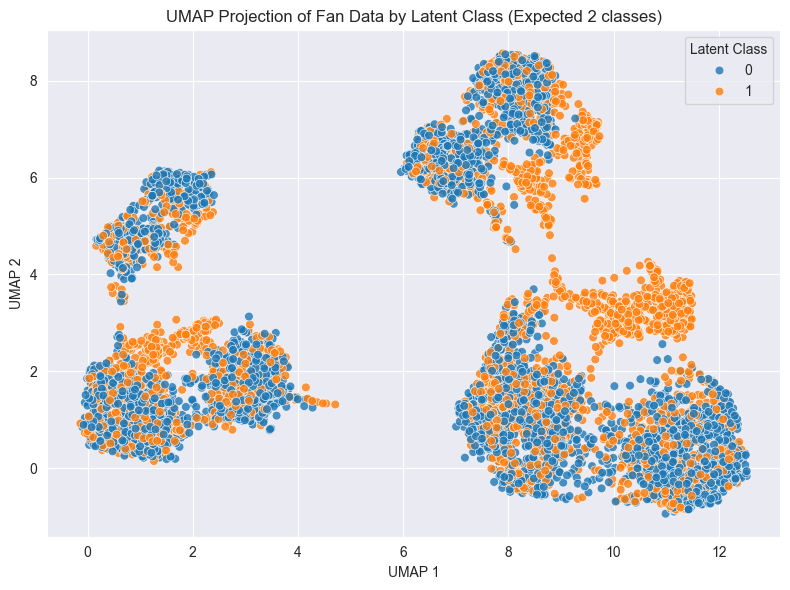

In [256]:
show_umap_projection(df_LCA, 2)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:08<00:00,  8.67s/it, max_LL=-1.99e+5, max_avg_LL=-27.4]


MODEL REPORT
    Measurement model parameters
          model_name                categorical_nan        
          class_no                                0       1
          param variable                                   
          pis   area_0                       0.1827  0.1784
                area_1                       0.0298  0.0317
                area_10                      0.1774  0.2492
                area_11                      0.0392  0.0399
                area_12                      0.0419  0.0411
                area_13                      0.0380  0.0384
                area_2                       0.0112  0.0105
                area_21                      0.0445  0.0076
                area_3                       0.0353  0.0355
                area_4                       0.0438  0.0374
                area_5                       0.0596  0.0491
                area_6                       0.0158  0.0085
                area_7                       0.0252  0

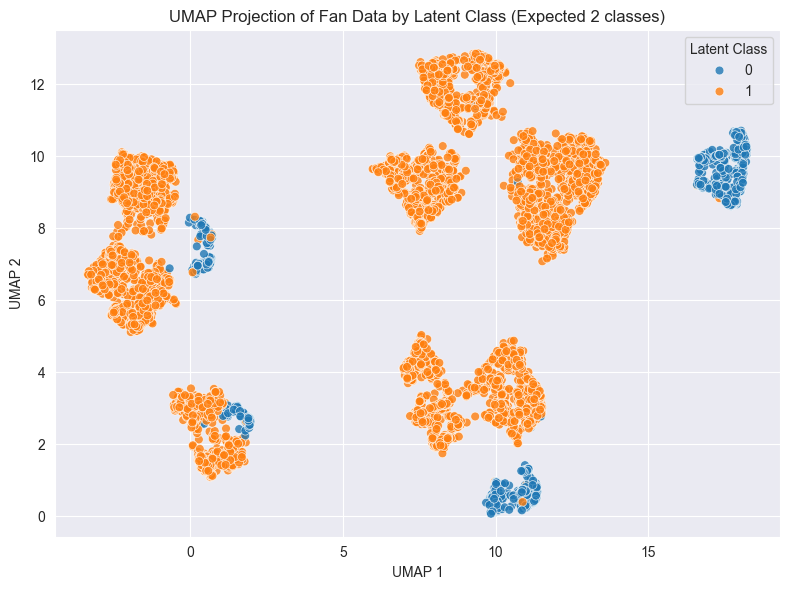

In [257]:
cat_columns_to_remove = ["class", "blood", "aspect", "lunar"]

n_comp = 2
df_cat_adjusted = df_cat.drop(columns=cat_columns_to_remove)
categorical_model = StepMix(n_components=n_comp, measurement="categorical_nan", verbose=1, random_state=413)
categorical_model.fit(df_cat_adjusted)
df_cat_adjusted["latent_class"] = categorical_model.predict(df_cat_adjusted)
show_umap_projection(df_cat_adjusted, n_comp)

In [258]:
mixed_data, _ = get_mixed_descriptor(
    dataframe=df_LCA,
    continuous=list(df_cont.columns),
    binary=list(df_bool.columns),
    categorical=list(df_cat.columns),
)

# Override the mixed descriptor to allow NaN values
mixed_descriptor = {
    "continuous_nan": {"model": "continuous_nan", "n_columns": 28},
    "binary_nan": {"model": "binary_nan", "n_columns": 19},
    "categorical_nan": {"model": "categorical_nan", "n_columns": 21}
}

# Fit the model
model = StepMix(n_components=4, measurement=mixed_descriptor, verbose=1, random_state=413)
model.fit(mixed_data)


df_LCA["latent_class"] = model.predict(mixed_data)
df_LCA.sample(5)

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/1 [00:00<?, ?it/s]D:\DevelopmentD\HomestuckCommunityCensus2025\.venv\lib\site-packages\stepmix\emission\gaussian.py:360: RuntimeWarning:

divide by zero encountered in true_divide

D:\DevelopmentD\HomestuckCommunityCensus2025\.venv\lib\site-packages\stepmix\emission\gaussian.py:361: RuntimeWarning:

invalid value encountered in multiply

D:\DevelopmentD\HomestuckCommunityCensus2025\.venv\lib\site-packages\stepmix\emission\gaussian.py:369: RuntimeWarning:

divide by zero encountered in log

D:\DevelopmentD\HomestuckCommunityCensus2025\.venv\lib\site-packages\stepmix\emission\gaussian.py:371: RuntimeWarning:

invalid value encountered in add

D:\DevelopmentD\HomestuckCommunityCensus2025\.venv\lib\site-packages\scipy\special\_logsumexp.py:116: RuntimeWarning:

overflow encountered in exp

Initializations (n_init) :   0%|          | 0/1 [01:05<?, ?it/s]


KeyboardInterrupt: 

Mapping for categorical variables:
  is_from: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
  race: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}
  platform: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
  method: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10}
  favchar: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
  leastfavchar: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
  ship: {0: -1, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

Continuous variable profiles by latent class:
               age_log                                          \
                  mean    median       std       min       max   
latent_class                                                     
0             3.080399  3.091042  0.261609  1.791759  4.624973   

             days_since_fandom_join_log                                     \
                                  

C:\Users\PC\AppData\Local\Temp\ipykernel_26112\3553912926.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_profile[col]):


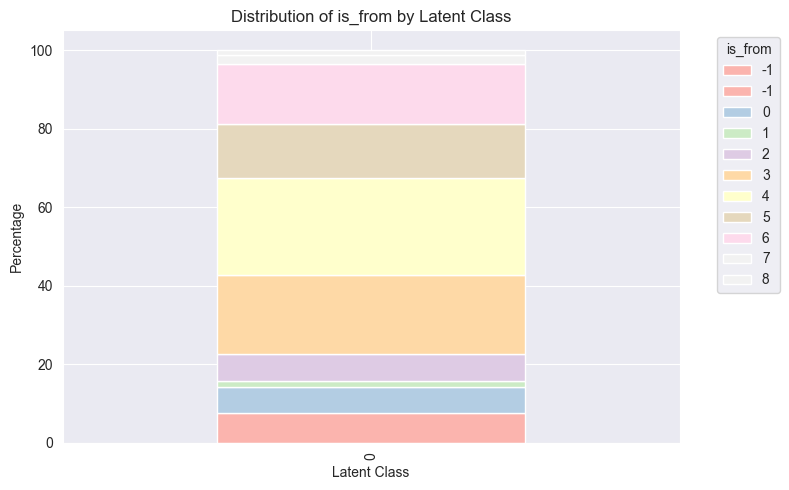


Categorical variable 'race' (percent distribution by latent class):
race                -1         0         1         2          3         4  \
latent_class                                                                
0             1.524935  5.206759  4.190136  1.621102  14.589916  0.824289   

race                 5         6         7         8  
latent_class                                          
0             67.60544  1.167743  0.920456  2.349224  


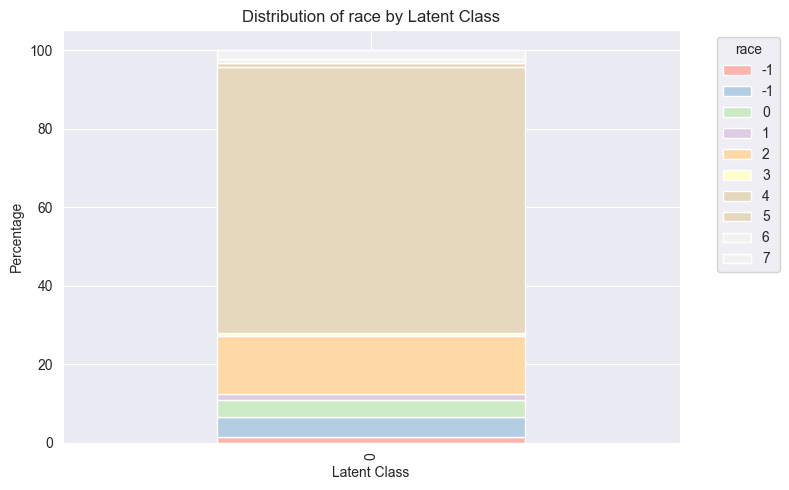


Categorical variable 'platform' (percent distribution by latent class):
platform             -1         0         1         2        3          4  \
latent_class                                                                
0             14.768512  0.577002  0.082429  3.393323  4.90452  57.659019   

platform              5         6  
latent_class                       
0             17.969501  0.645693  


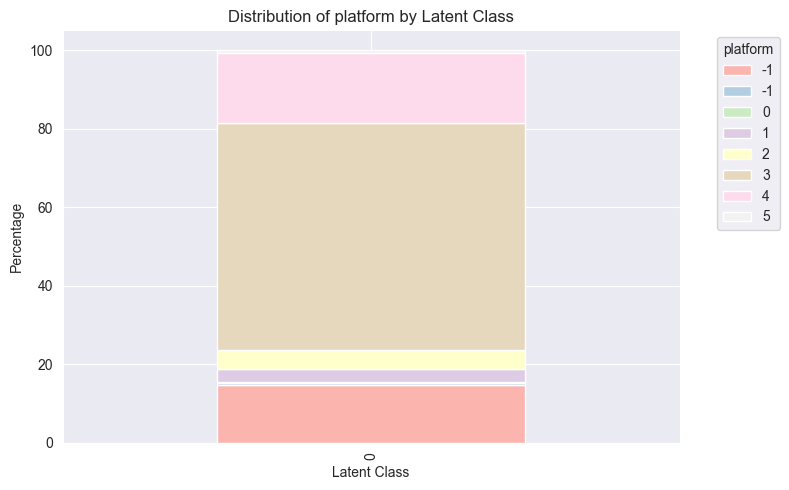


Categorical variable 'method' (percent distribution by latent class):
method              -1        0         1          2         3          4  \
latent_class                                                                
0             14.93337  0.15112  0.563264  22.118423  6.690479  12.062096   

method               5        6         7          8         9        10  
latent_class                                                              
0             0.769336  1.41503  0.686908  37.656271  1.428768  1.524935  


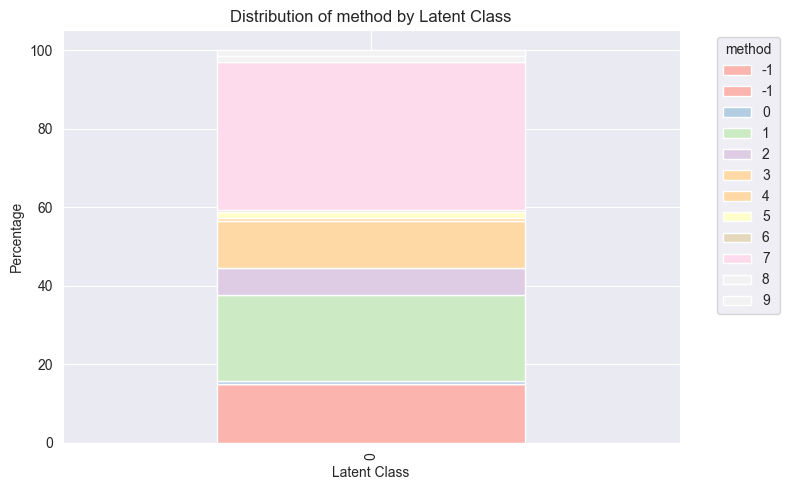


Categorical variable 'favchar' (percent distribution by latent class):
favchar             -1          0         1         2          3         4  \
latent_class                                                                 
0             1.305124  12.735266  4.080231  8.270367  10.097541  6.635527   

favchar              5          6        7         8         9  
latent_class                                                    
0             4.245089  35.719192  5.05564  6.113477  5.742547  


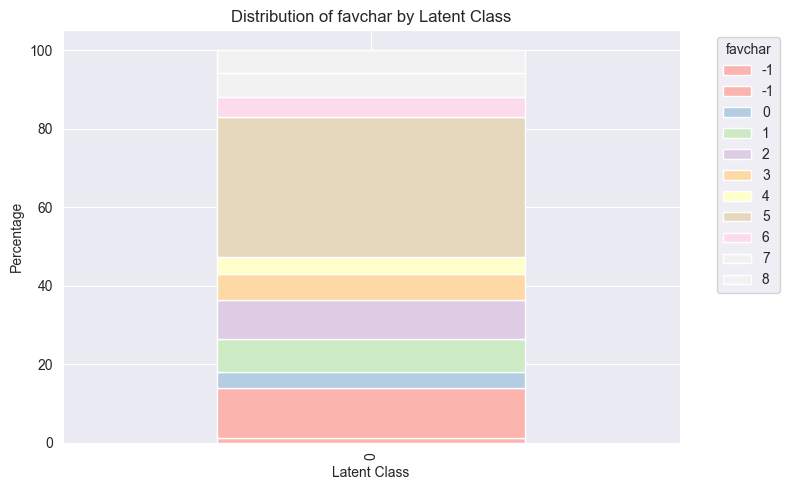


Categorical variable 'leastfavchar' (percent distribution by latent class):
leastfavchar        -1         0        1         2         3        4  \
latent_class                                                             
0             6.140953  3.970326  3.11856  9.383157  2.981179  4.90452   

leastfavchar         5          6        7          8          9  
latent_class                                                      
0             8.957274  10.015112  2.89875  37.381508  10.248661  


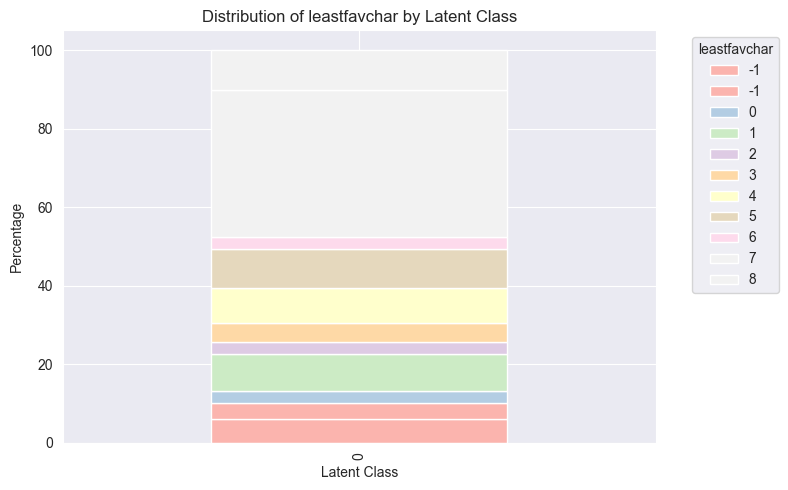


Categorical variable 'ship' (percent distribution by latent class):
ship                -1         0         1        2         3         4  \
latent_class                                                              
0             8.503915  2.610249  2.239319  3.79173  13.29853  2.939964   

ship                 5         6          7          8         9  
latent_class                                                      
0             2.266795  3.503228  10.880615  45.651875  4.313779  


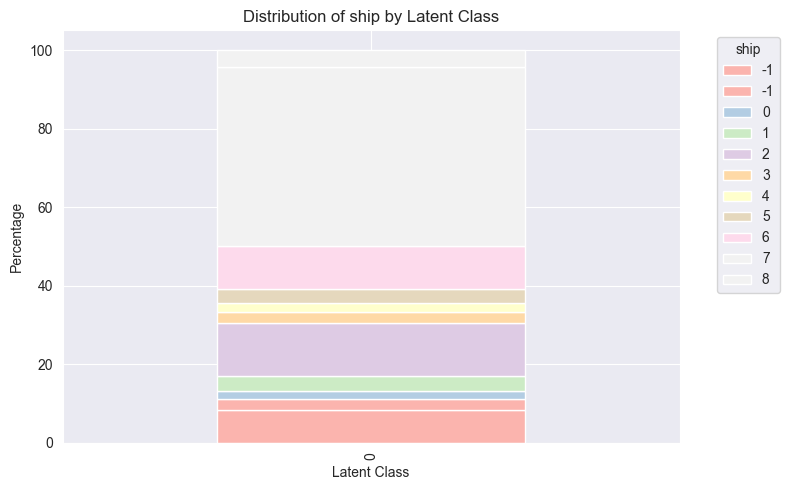

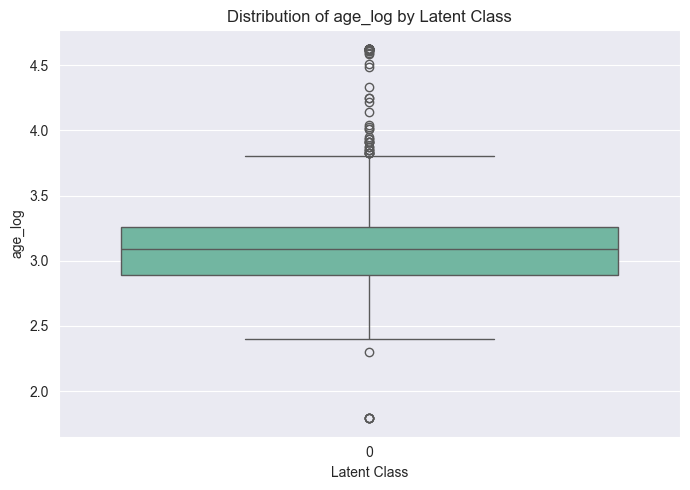

Chi-squared test for is_from: chi2=0.000, p=1, dof=0
Chi-squared test for race: chi2=0.000, p=1, dof=0
Chi-squared test for platform: chi2=0.000, p=1, dof=0
Chi-squared test for method: chi2=0.000, p=1, dof=0
Chi-squared test for favchar: chi2=0.000, p=1, dof=0
Chi-squared test for leastfavchar: chi2=0.000, p=1, dof=0
Chi-squared test for ship: chi2=0.000, p=1, dof=0


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

continuous_vars = ["age_log", "days_since_fandom_join_log", "days_since_last_read_log",
                   "econ_scale", "soc_scale", "hardcore_fan_score", "times_read",
                   "rates_homestuck", "rates_epilogues"]

categorical_vars = ["is_from", "race", "platform", "method", "favchar", "leastfavchar", "ship"]

# --------------------------
# Create a copy of the dataframe
# --------------------------
df_profile = df_LCA.copy()

# --------------------------
# Recover categorical labels and build mapping dictionaries
# --------------------------
# This most definitely doesn't work right now
mapping_dict = {}
for col in categorical_vars:
    # If the column is not categorical, convert to category.
    if not pd.api.types.is_categorical_dtype(df_profile[col]):
        df_profile[col] = df_profile[col].astype("category")
    # Build the mapping: this will be a dict like {0: "label_A", 1: "label_B", ...}
    mapping_dict[col] = dict(enumerate(df_profile[col].cat.categories))

print("Mapping for categorical variables:")
for col, mapping in mapping_dict.items():
    print(f"  {col}: {mapping}")

# --------------------------
# 1. Continuous variable profiling by latent class
# --------------------------
cont_profiles = df_profile.groupby("latent_class")[continuous_vars].agg(["mean", "median", "std", "min", "max"])
print("\nContinuous variable profiles by latent class:")
print(cont_profiles)

# --------------------------
# 2. Categorical variable profiling
# --------------------------
for col in categorical_vars:
    # Use crosstab to get the distribution (as percentages) of each category by latent class.
    ct = pd.crosstab(df_profile["latent_class"], df_profile[col], normalize="index") * 100
    print(f"\nCategorical variable '{col}' (percent distribution by latent class):")
    print(ct)
    # When plotting, the x-axis will show the numeric codes.
    # We then replace these with the original labels by setting the tick labels.
    ax = ct.plot.bar(stacked=True, figsize=(8, 5), colormap='Pastel1', title=f"Distribution of {col} by Latent Class")
    plt.ylabel("Percentage")
    plt.xlabel("Latent Class")
    # Replace the legend labels using the mapping dictionary.
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [mapping_dict[col].get(int(lbl), lbl) for lbl in labels]
    ax.legend(handles, new_labels, title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# --------------------------
# 3. Visualize individual continuous variables across clusters.
# --------------------------
plt.figure(figsize=(7, 5))
sns.boxplot(x="latent_class", y="age_log", data=df_profile, palette="Set2")
plt.title("Distribution of age_log by Latent Class")
plt.xlabel("Latent Class")
plt.ylabel("age_log")
plt.tight_layout()
plt.show()

# --------------------------
# 4. Run ANOVA tests for continuous variables.
# --------------------------
for var in continuous_vars:
    groups = [group[var].dropna().values for _, group in df_profile.groupby("latent_class")]
    if len(groups) > 1:
        F, p = stats.f_oneway(*groups)
        print(f"ANOVA for {var}: F={F:.3f}, p={p:.3g}")

# --------------------------
# 5. Run chi-squared tests for categorical variables.
# --------------------------
for col in categorical_vars:
    cont_table = pd.crosstab(df_profile["latent_class"], df_profile[col]).fillna(0)
    chi2, p, dof, expected = chi2_contingency(cont_table)
    print(f"Chi-squared test for {col}: chi2={chi2:.3f}, p={p:.3g}, dof={dof}")


# Data extraction


In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import numpy as np

# Settings
pd.set_option('future.no_silent_downcasting', True)

# Load data
csv_path = 'census_results.csv'
df_extract = pd.read_csv(csv_path, low_memory=False)

# Drop the first five rows (test data)
df_extract.drop(index=[0, 1, 2, 3, 4], inplace=True)

# Remove duplicate/troll answers based on manual check
submission_ids_to_drop = [
    # Explicitly dropped (trolls, worse duplicates, etc.)
    "R7Z8OK", "o4A1AV", "rxrxAp", "5yzDOM", "rxdxeM", "4g8YRA", "9zWyYK",
    "rxdxeM", "9zWyYK", "ed68xo", "Xxx9VzY", "Nppg5Gb", "QKKOxJG"
    # Others from confirmed duplicate IDs
    "Q6DVbX", "YLQvAN", "0pxY79", "XKDajY", "E4XOvq", "d5Dyvq", "2M4j4M",
    "XKqM7g", "E4XoEo", "Pa04xB", "BPXrgN", "GNpoLp", "b0MzME", "o48L7P",
    "M9jkD8", "M9kN8Y", "44XgVPB", "jd10Yx", "ob6a4zN", "Np5V1qN", "eqZL7bo",
    "BO908Y", "R706OQ", "ZpNKqB", "gR4YbD", "OpQ4Qg", "444KDlk", "5BKgEKd",
    "q2Yjad", "11YBAl"
]

# Rename columns
if "Submission ID" in df.columns:
    df_extract = df_extract[~df_extract["Submission ID"].isin(submission_ids_to_drop)]
    df_extract.rename(columns={"Submission ID": "submission_id"}, inplace=True)
    df_extract.drop(columns=["Respondent ID"], errors="ignore", inplace=True)


In [68]:
from sklearn.utils import shuffle
columns_to_tally = ['Where did you find this survey?', "Respondent's country", 'How old are you?', 'Which gender do you identify the most with?', 'Are you transgender?', 'Which orientation do you identify the most with?', "What's your relationship status?", 'Which ethnicity or race/s do you identify the most with?\n', '"I\'m belong to/I am/I have..."', 'Economic scale (1 Left to 5 Right)', 'Social scale (1 Authoritarian to 5 Libertarian)', 'Select your 3 least favorite characters!', 'Which 3 characters had the best complete arc?', 'Which 3 characters had the worst arc?', "What's your favorite ship?", 'Select your 3 favorite characters!', 'Are you employed?', "Which of these subjects is closest to what you studied/you're studying?", 'On a scale of 0 (accidentally started this survey) to 10 (has put thousands of hours into the comic/fandom) how hardcore a fan of Homestuck are you?', 'What field do you work in?', 'Approximately when did you join the Homestuck fandom?', 'How did you first learn of Homestuck?', "Are you participating or have you ever participated in one of /r/homestuck's group rereads?", 'How many times have you "read" Homestuck?', 'What is your favorite Act?', 'Approximately when did you last "read" the comic?', 'What platform did you last "read" Homestuck on (including active rereads)?', 'How did you last "read" Homestuck (including active rereads)?', 'Which of these Homestuck franchiselets have you perused? [Homestuck]', 'Which of these Homestuck franchiselets have you perused? [HS Epilogues]', 'Which of these Homestuck franchiselets have you perused? [SBaHJ]', 'Which of these Homestuck franchiselets have you perused? [Problem Sleuth]', 'Which of these Homestuck franchiselets have you perused? [Jailbreak]', 'Which of these Homestuck franchiselets have you perused? [Bard Quest]', 'Which of these Homestuck franchiselets have you perused? [Paradox Space]', 'Which of these Homestuck franchiselets have you perused? [Namco High]', 'Which of these Homestuck franchiselets have you perused? [HSBC/HS^2]', 'Which of these Homestuck franchiselets have you perused? [Skaianet Systems]', 'Which of these Homestuck franchiselets have you perused? [Psycholonials]', 'How do you rate Homestuck overall?', "How do you rate Homestuck's ending?", 'How do you rate the Homestuck Epilogues?', 'How do you rate Problem Sleuth?', 'How do you rate Paradox Space?', 'How do you rate Homestuck: Beyond Canon/Homestuck^2?', 'How do you rate Hiveswap Act 1?', 'How do you rate Hiveswap Act 2?', 'How do you rate Hiveswap Friendsim?', 'How do you rate Pesterquest?', 'How do you rate Psycholonials?', 'Did you fund the Homestuck Kickstarter?', 'Class', 'Aspect', 'What is your Lunar Sway?', 'What is your Blood Color?', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanart]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanmusic]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanvideos]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Fanfiction/adventures]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Cosplay]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Theories]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Roleplay]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Fangames/mods]', 'How often have you created fanwork for the Homestuck fandom, and in which ways? [Other (i.e. wikis)]', 'Would you buy quest bed bedding?', 'Would you buy a continuation of the Homestuck books from Cascade onwards?', 'Would you buy a physical SBURB guide/lorebook à la Wizardology? ', 'Do you want more official Homestuck musicians to individually add all their Homestuck songs to streaming, à la Bowmanstuck?', 'Would you buy a physical copy of the Homestuck Soundtrack? ', 'Would you buy a new physical book of official non-canon Homestuck side comics à la Paradox Space?', 'Would you buy/stream new official Homestuck music albums?' , 'Which of these Homestuck franchiselets have you perused? [Hiveswap Act 1]', 'Which of these Homestuck franchiselets have you perused? [Hiveswap Act 2]', 'Which of these Homestuck franchiselets have you perused? [Friendsim]', 'Which of these Homestuck franchiselets have you perused? [Pesterquest]', 'Share your merch wishlist beyond the above', 'What\'s your favorite "old" fanwork?', 'What\'s your favorite "current" fanwork?']

SAVE = False

if SAVE:
    for column in columns_to_tally:
        print(f"Saving column {column}...")
        normalized_column = re.sub(r"[^a-zA-Z0-9]", "_", column).lower()
        column_df = df_extract[column]
        column_shuffled = shuffle(column_df).reset_index(drop=True)
        column_shuffled.to_csv(f"answer_csvs/{normalized_column}.csv", index=False)

TALLY = True

if TALLY:
    html_tables = []
    for column in columns_to_tally:
        print(f"Tallying column {column}...")
        threshold = 5
        column_df = df_extract[column]
        counts = column_df.value_counts(dropna=False)
        total = counts.sum()

        # Merge rare categories (< threshold) into "Other"
        merged_counts = counts[counts >= threshold].copy()
        other_sum = counts[counts < threshold].sum()

        if other_sum > 0:
            merged_counts["Other"] = other_sum

        percentages = (merged_counts / total * 100).round(1)

        summary_df = pd.DataFrame({
            "value": merged_counts.index,
            "count": merged_counts.values,
            "percentage": percentages.values
        })

        # Save summary
        normalized_column = re.sub(r"[^a-zA-Z0-9]", "_", column).lower()
        summary_df.to_csv(f"result_csvs/{normalized_column}.csv", index=False)

        # Generate HTML table for this column
        html_table = f'<div class="answer-table">\n<h4>{column}</h4>\n'
        html_table += summary_df.to_html(index=False, border=0, classes='table', justify='left')
        html_table += "\n</div>"
        html_tables.append(html_table)

    full_html = "\n".join(html_tables)
    with open("survey_summary_tables.html", "w", encoding="utf-8") as file:
        file.write(full_html)



Tallying column Where did you find this survey?...
Tallying column Respondent's country...
Tallying column How old are you?...
Tallying column Which gender do you identify the most with?...
Tallying column Are you transgender?...
Tallying column Which orientation do you identify the most with?...
Tallying column What's your relationship status?...
Tallying column Which ethnicity or race/s do you identify the most with?
...
Tallying column "I'm belong to/I am/I have..."...
Tallying column Economic scale (1 Left to 5 Right)...
Tallying column Social scale (1 Authoritarian to 5 Libertarian)...
Tallying column Select your 3 least favorite characters!...
Tallying column Which 3 characters had the best complete arc?...
Tallying column Which 3 characters had the worst arc?...
Tallying column What's your favorite ship?...
Tallying column Select your 3 favorite characters!...
Tallying column Are you employed?...
Tallying column Which of these subjects is closest to what you studied/you're study

In [ ]:
# Sorry that the code is shit, I had to speedrun all of this in two weeks
# (Thank fucking god ChatGPT can write boilerplate if you guide it properly)